### 1. Librerias

In [1]:
import pandas as pd
import numpy as np

In [2]:
#pip install optbinning
#pip install mlxtend

### 2. Carga de datos

In [3]:
ruta = 'C:/Users/Daniel/Documents/proyectos/riesgos/one year pd/chap2oneypd.csv'

In [4]:
df = pd.read_csv(ruta)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25906 entries, 0 to 25905
Data columns (total 44 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             25906 non-null  int64  
 1   vintage_year                   25906 non-null  int64  
 2   monthly_installment            25906 non-null  float64
 3   loan_balance                   25906 non-null  float64
 4   bureau_score                   25473 non-null  float64
 5   num_bankrupt_iva               25473 non-null  float64
 6   time_since_bankrupt            25473 non-null  float64
 7   num_ccj                        25473 non-null  float64
 8   time_since_ccj                 25473 non-null  float64
 9   ccj_amount                     25473 non-null  float64
 10  num_bankrupt                   25473 non-null  float64
 11  num_iva                        25473 non-null  float64
 12  min_months_since_bankrupt      25473 non-null 

### 3. Limpieza y tratamiento de datos

In [6]:
df['max_arrears_12m'] = df['max_arrears_12m'].round(4)
df['arrears_months'] = df['arrears_months'].round(4)

In [7]:
# armar una función con lambda para que haga el cambio en todas las columnas que tengan 'date' en su nombre
from datetime import datetime
df['origination_date2'] = pd.to_datetime(df['origination_date'])
df['origination_date2'] = df['origination_date2'].dt.strftime('%Y-%m-%d')

df['maturity_date2'] = pd.to_datetime(df['maturity_date'])
df['maturity_date2'] = df['maturity_date2'].dt.strftime('%Y-%m-%d')

df['recent_arrears_date2'] = pd.to_datetime(df['recent_arrears_date'])
df['recent_arrears_date2'] = df['recent_arrears_date2'].dt.strftime('%Y-%m-%d')

C:\Users\Daniel\AppData\Local\Temp\ipykernel_13156\2291711405.py:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['origination_date2'] = pd.to_datetime(df['origination_date'])
C:\Users\Daniel\AppData\Local\Temp\ipykernel_13156\2291711405.py:6: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['maturity_date2'] = pd.to_datetime(df['maturity_date'])
C:\Users\Daniel\AppData\Local\Temp\ipykernel_13156\2291711405.py:9: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['recent_arrears_date2'] = pd.to_datetime(df['recent_arrears_date'])


#### 3.1 Identificación de 'NaN'

In [8]:
# recent_arrears_date, months_since_2mia tienen un alto porcentaje de 'nan' por lo tanto no se consideran 
# eliminación de los registros con nan de la variables bureau_score,num_bankrupt_iva,time_since_bankrupt,num_ccj,time_since_ccj,ccj_amount,num_bankrupt
# num_iva,min_months_since_bankrupt

df.isna().sum().to_frame()


,0
id,0
vintage_year,0
monthly_installment,0
loan_balance,0
bureau_score,433
num_bankrupt_iva,433
time_since_bankrupt,433
num_ccj,433
time_since_ccj,433
ccj_amount,433


In [9]:
# recent_arrears_date, months_since_2mia tienen un alto porcentaje de 'nan' por lo tanto no se consideran dentro del análisis
df2 = df.drop(['recent_arrears_date','months_since_2mia','recent_arrears_date2'],axis=1)

In [10]:
# eliminación los registros con 'nan' de la variables bureau_score,num_bankrupt_iva,time_since_bankrupt,num_ccj,time_since_ccj,ccj_amount,num_bankrupt
# num_iva,min_months_since_bankrupt
df2 = df2[(df2.bureau_score.notna())].reset_index(drop=True)

In [11]:
# eliminación los registros con 'nan' de la variable avg_mia_6m,max_arrears_bal_6m,max_mia_6m,avg_bal_6m,avg_bureau_score_6m 
df2 = df2[(df2.avg_bureau_score_6m.notna())].reset_index(drop=True)

In [12]:
# eliminación los registros con 'nan' de la variable region
df2 = df2[(df2.region.notna())].reset_index(drop=True)

In [13]:
# validación de la no exitencia de atributos 'NaN' dentro del dataframe
df2.isna().sum().to_frame()

,0
id,0
vintage_year,0
monthly_installment,0
loan_balance,0
bureau_score,0
num_bankrupt_iva,0
time_since_bankrupt,0
num_ccj,0
time_since_ccj,0
ccj_amount,0


#### 3.1 Contrucción de marca de default (tgt) 

In [14]:
df2['default_event'] = np.where((df2.arrears_event == 1) | (df2.bankrupt_event == 1) | (df2.term_expiry_event == 1),1,0)

In [15]:
df2.default_event.value_counts(normalize = True)*100
# con dataframe df quitando registros con 'nan'
# %no evento 0 = 94.742531 
# %evento 1 = 5.257469
# nos damos cuenta que el dataframe se sncuentr desbalanceda en la variable objetivo (evento y no evento)

default_event
0    94.753583
1     5.246417
Name: proportion, dtype: float64

In [16]:
# unidad muestral
um   = ['id']
# target, marca de incumplimiento
tgt = ['default_event']

# varibles continuas
var_con= ['monthly_installment','loan_balance','bureau_score','time_since_bankrupt','time_since_ccj',
        'ccj_amount','min_months_since_bankrupt','ltv','arrears_months'
        ,'mob','remaining_mat','loan_term','max_arrears_12m','max_arrears_bal_6m','avg_bal_6m','avg_bureau_score_6m',
        'cc_util','annual_income','months_since_recent_cc_delinq'
        ]

# variables categoricas
var_cat = ['num_bankrupt_iva','num_ccj','num_bankrupt','num_iva','pl_flag','region','repayment_type','arrears_status','arrears_segment',
           'live_status','repaid_status','month','arrears_event','bankrupt_event','term_expiry_event','worst_arrears_status','avg_mia_6m',
           'max_mia_6m','emp_length']

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

porcentaje de tgt:  5.246416650304339
porcentaje de no tgt:  94.75358334969566


Text(0.5, 1.0, 'conteo de casos de fraude')

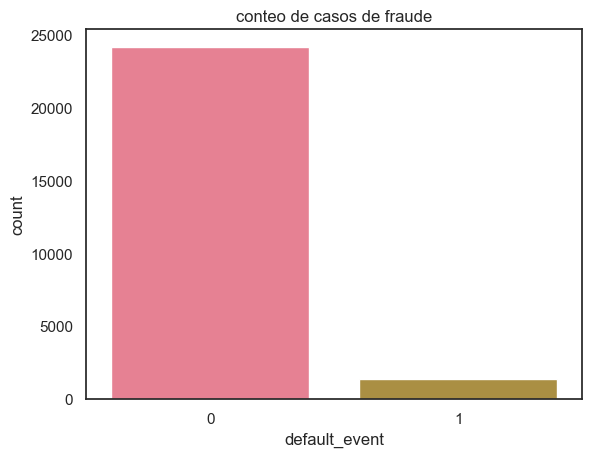

In [18]:
# cases of default and non default
print('porcentaje de tgt: ',df2[tgt].value_counts()[1] /df2.shape[0] * 100)
print('porcentaje de no tgt: ',df2[tgt].value_counts()[0] /df2.shape[0] * 100)
sns.set_theme(style = 'white',palette = 'husl')
ax = sns.countplot(x = 'default_event' , data = df2)
ax.set_title('conteo de casos de fraude')

In [19]:
df2['num_bankrupt_iva'].head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: num_bankrupt_iva, dtype: float64

Text(0.5, 1.0, 'Cases of default and non default according with num_ccj')

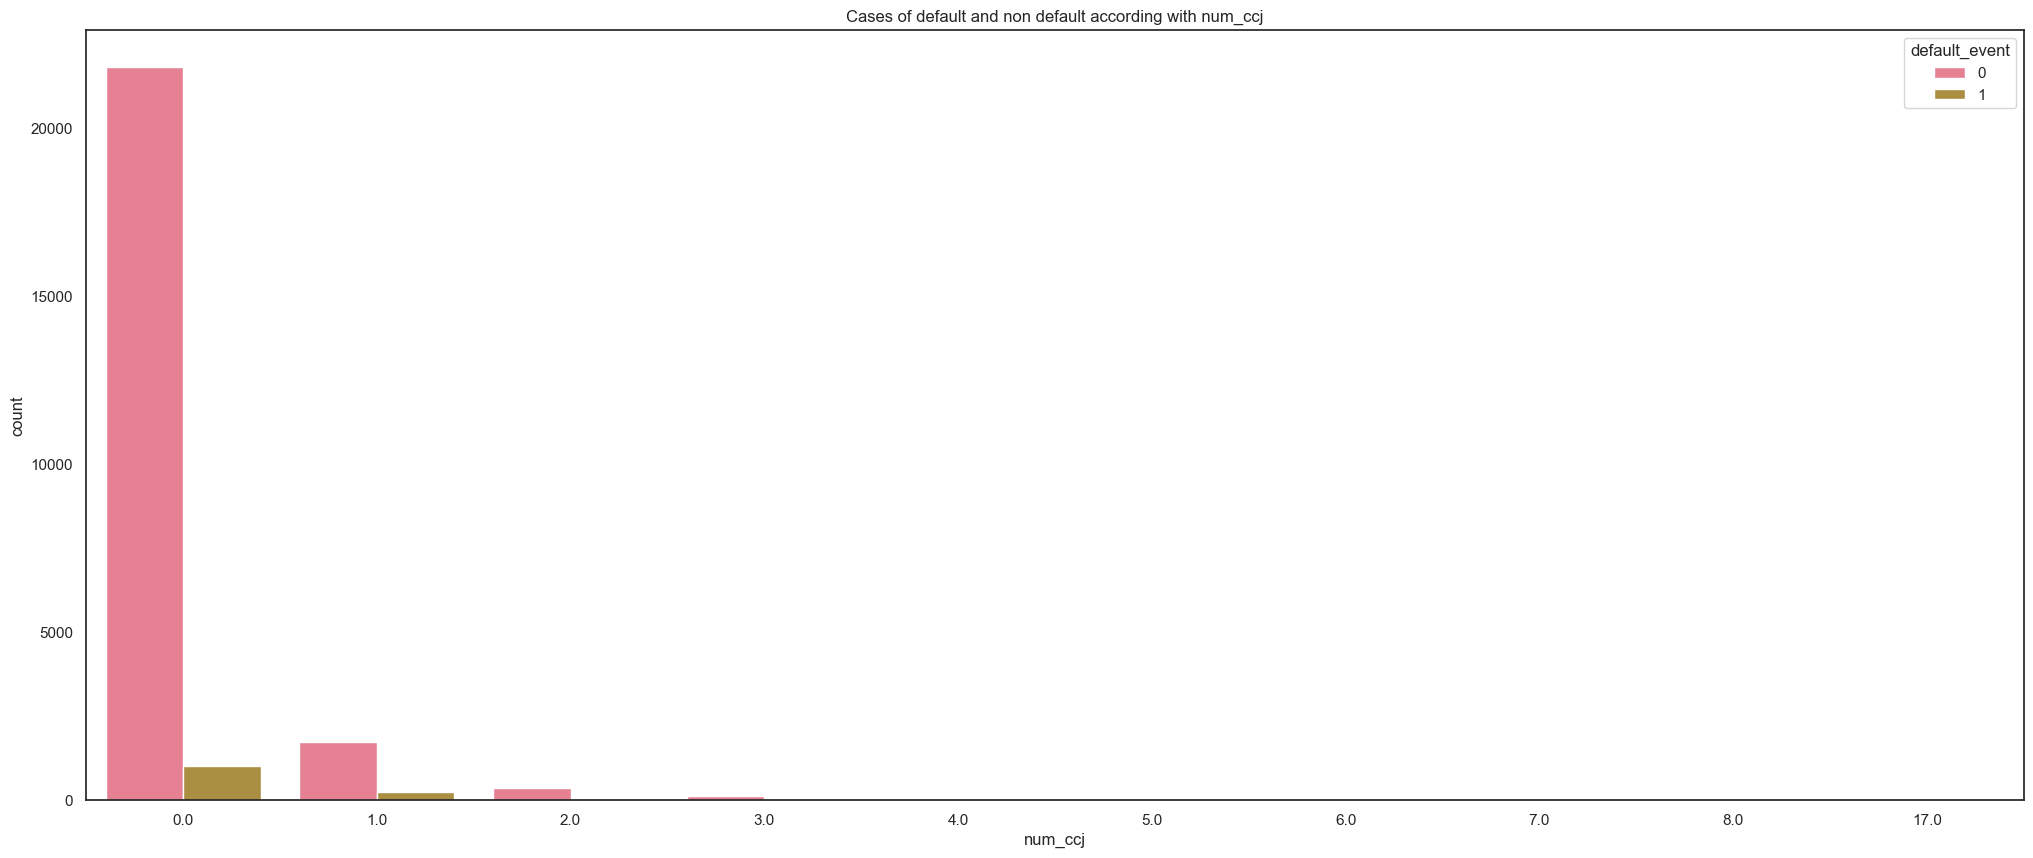

In [20]:
# Cases of default and non default , variable num_ccj
plt.figure(1,figsize = (25,10))
sns.countplot(hue = df2.default_event, x = df2.num_ccj)
plt.title('Cases of default and non default according with num_ccj')

Text(0.5, 1.0, 'Cases of default and non default according with num_bankrupt')

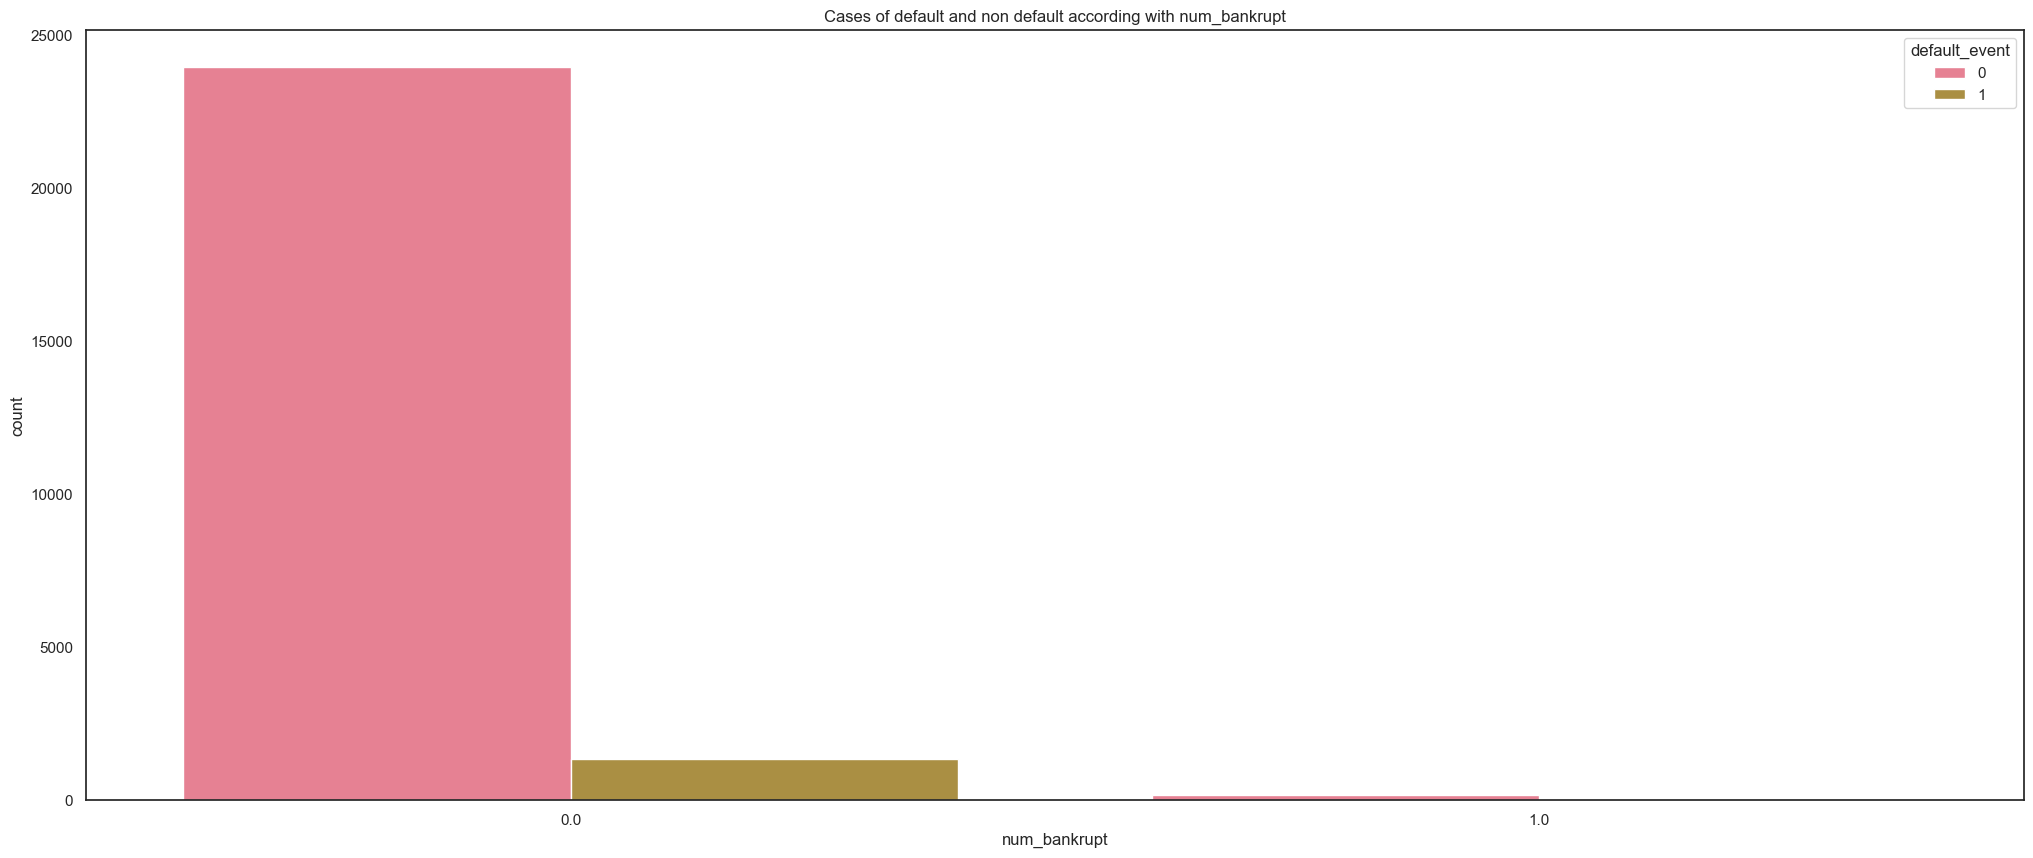

In [21]:
# Cases of default and non default , variable num_bankrupt
plt.figure(1,figsize = (25,10))
sns.countplot(hue = df2.default_event, x = df2.num_bankrupt)
plt.title('Cases of default and non default according with num_bankrupt')

Text(0.5, 1.0, 'Cases of default and non default according with num_iva')

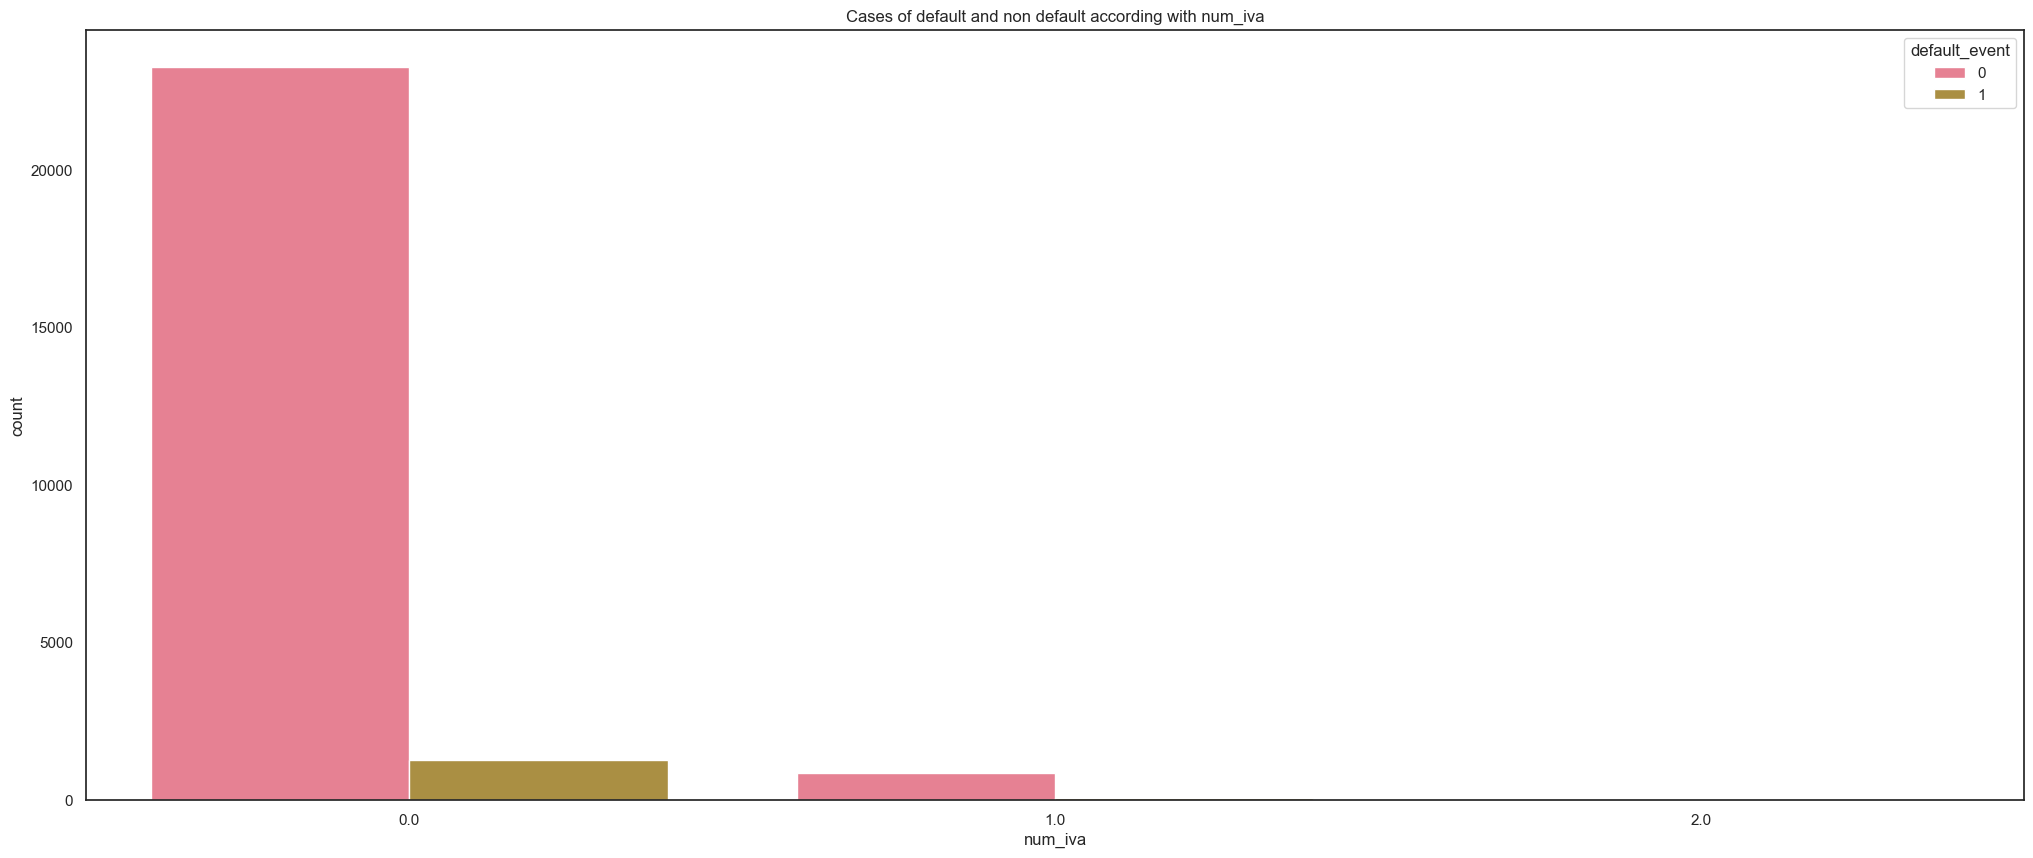

In [22]:
# Cases of default and non default , variable num_iva
plt.figure(1,figsize = (25,10))
sns.countplot(hue = df2.default_event, x = df2.num_iva)
plt.title('Cases of default and non default according with num_iva')

#'num_iva','pl_flag','region','repayment_type','arrears_status','arrears_segment',
#           'live_status','repaid_status','month','arrears_event','bankrupt_event','term_expiry_event','worst_arrears_status','avg_mia_6m',
#           'max_mia_6m','emp_length']

Text(0.5, 1.0, 'Cases of default and non default according with pl_flag')

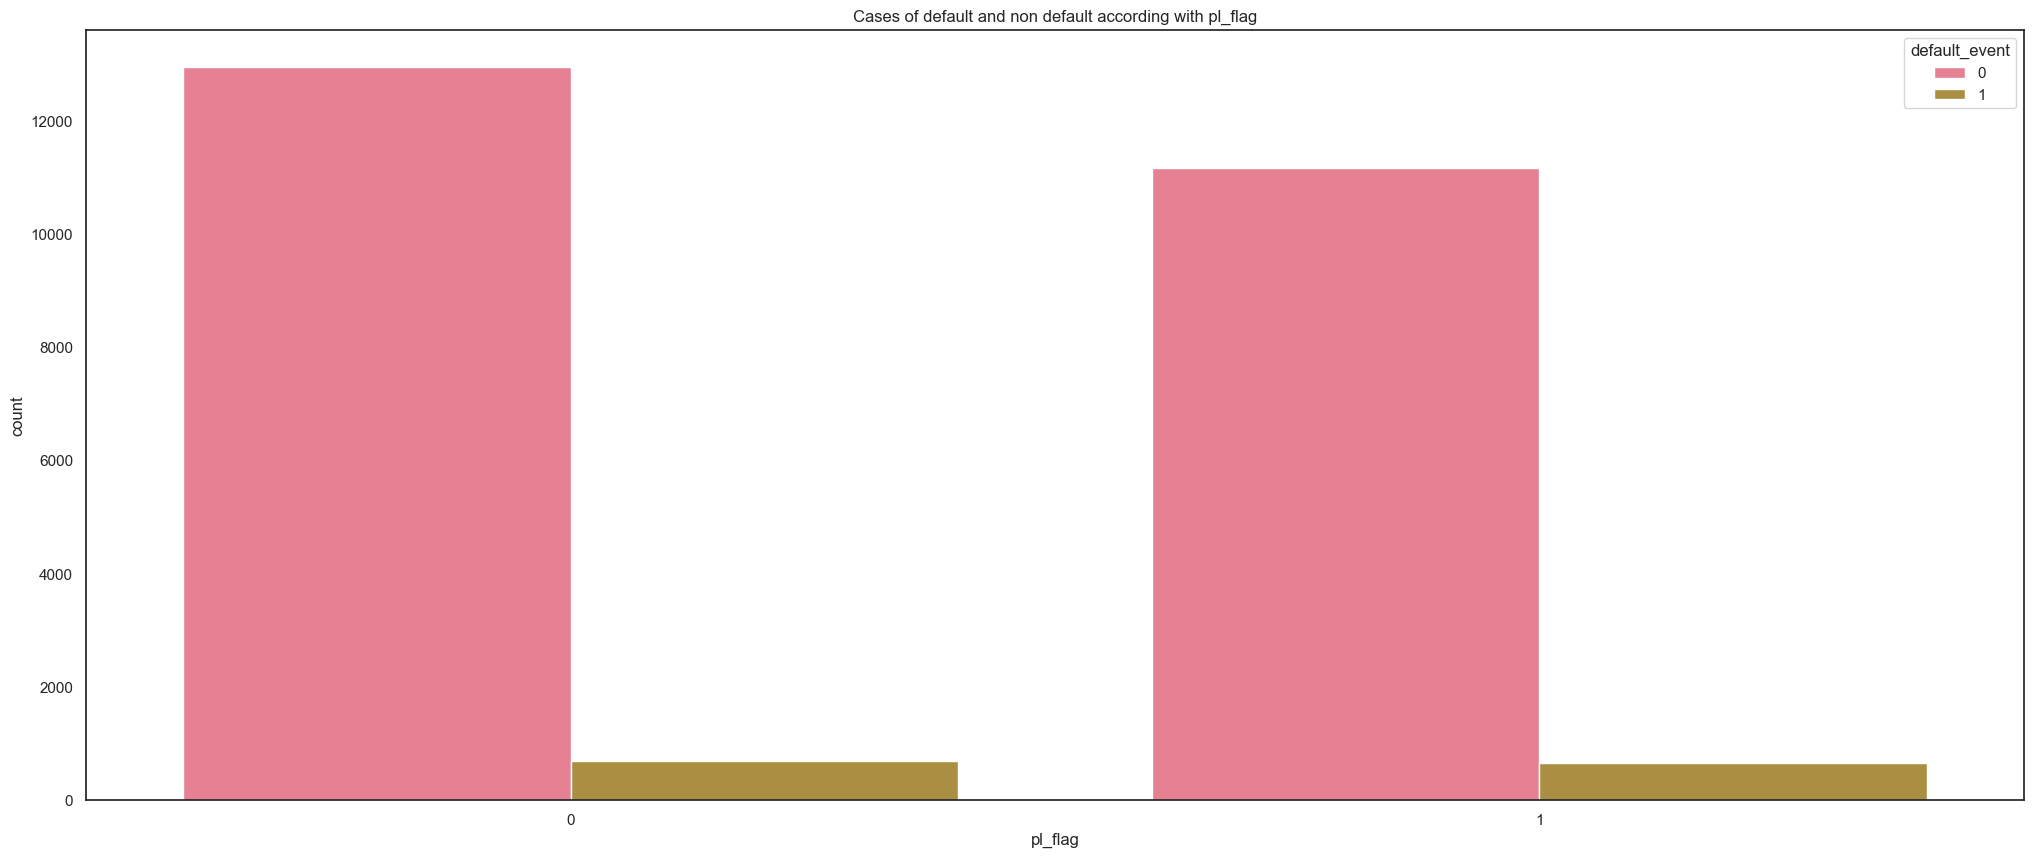

In [23]:
# Cases of default and non default , variable pl_flag
plt.figure(1,figsize = (25,10))
sns.countplot(hue = df2.default_event, x = df2.pl_flag)
plt.title('Cases of default and non default according with pl_flag')

#'num_iva','pl_flag','region','repayment_type','arrears_status','arrears_segment',
#           'live_status','repaid_status','month','arrears_event','bankrupt_event','term_expiry_event','worst_arrears_status','avg_mia_6m',
#           'max_mia_6m','emp_length']

Text(0.5, 1.0, 'Cases of default and non default according with region')

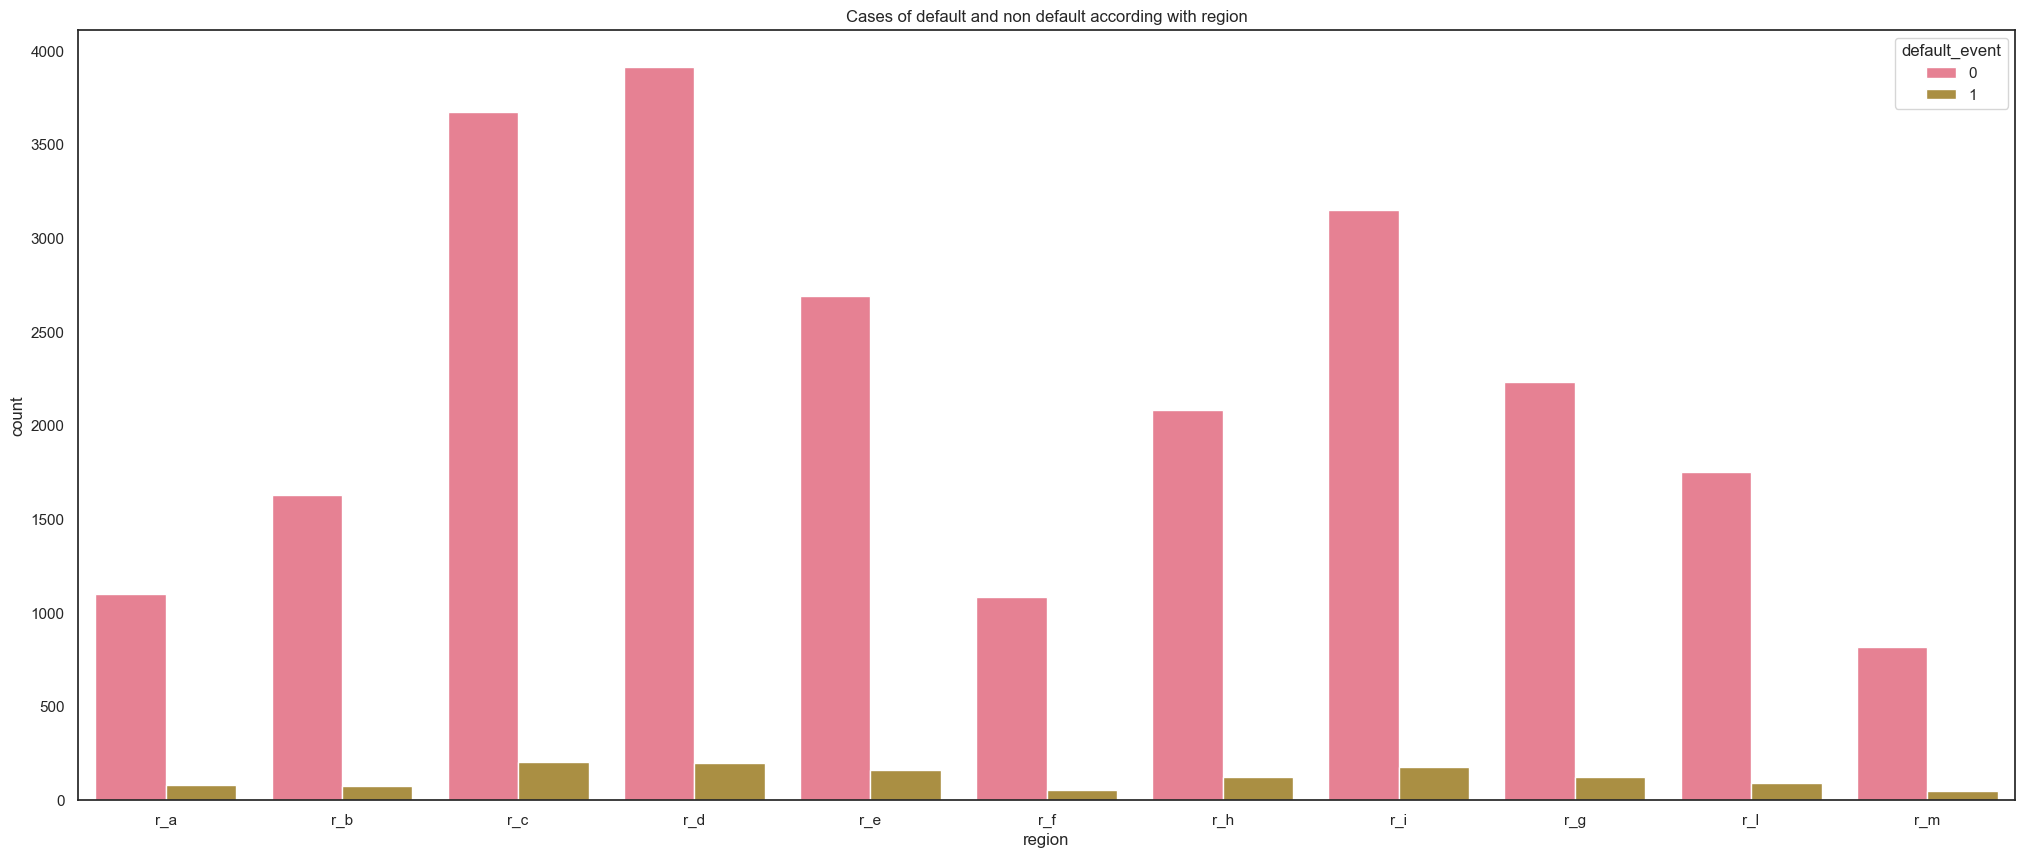

In [24]:
# Cases of default and non default , variable region
plt.figure(1,figsize = (25,10))
sns.countplot(hue = df2.default_event, x = df2.region)
plt.title('Cases of default and non default according with region')

## ok pl_flag, region

#'num_iva','pl_flag','region','repayment_type','arrears_status','arrears_segment',
#           'live_status','repaid_status','month','arrears_event','bankrupt_event','term_expiry_event','worst_arrears_status','avg_mia_6m',
#           'max_mia_6m','emp_length']

Text(0.5, 1.0, 'Cases of default and non default according with repayment_type')

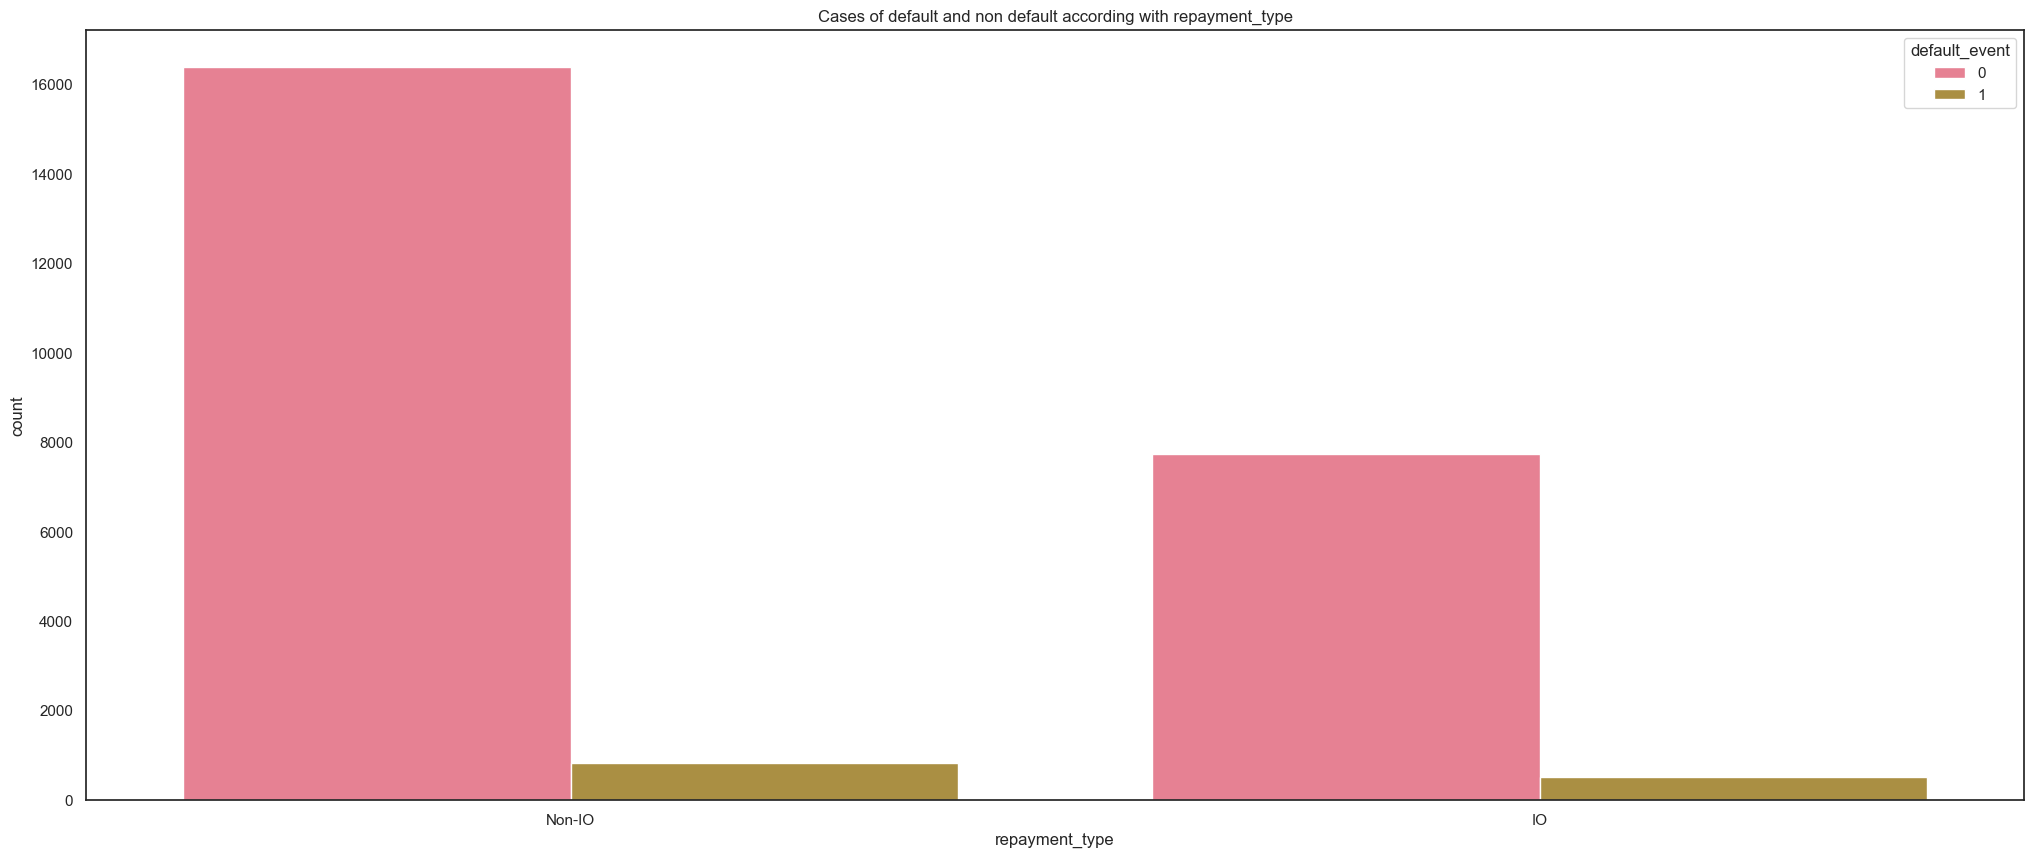

In [25]:
# Cases of default and non default , variable repayment_type
plt.figure(1,figsize = (25,10))
sns.countplot(hue = df2.default_event, x = df2.repayment_type)
plt.title('Cases of default and non default according with repayment_type')

## ok pl_flag, region, repayment_type

#'num_iva','pl_flag','region','repayment_type','arrears_status','arrears_segment',
#           'live_status','repaid_status','month','arrears_event','bankrupt_event','term_expiry_event','worst_arrears_status','avg_mia_6m',
#           'max_mia_6m','emp_length']

Text(0.5, 1.0, 'Cases of default and non default according with arrears_status')

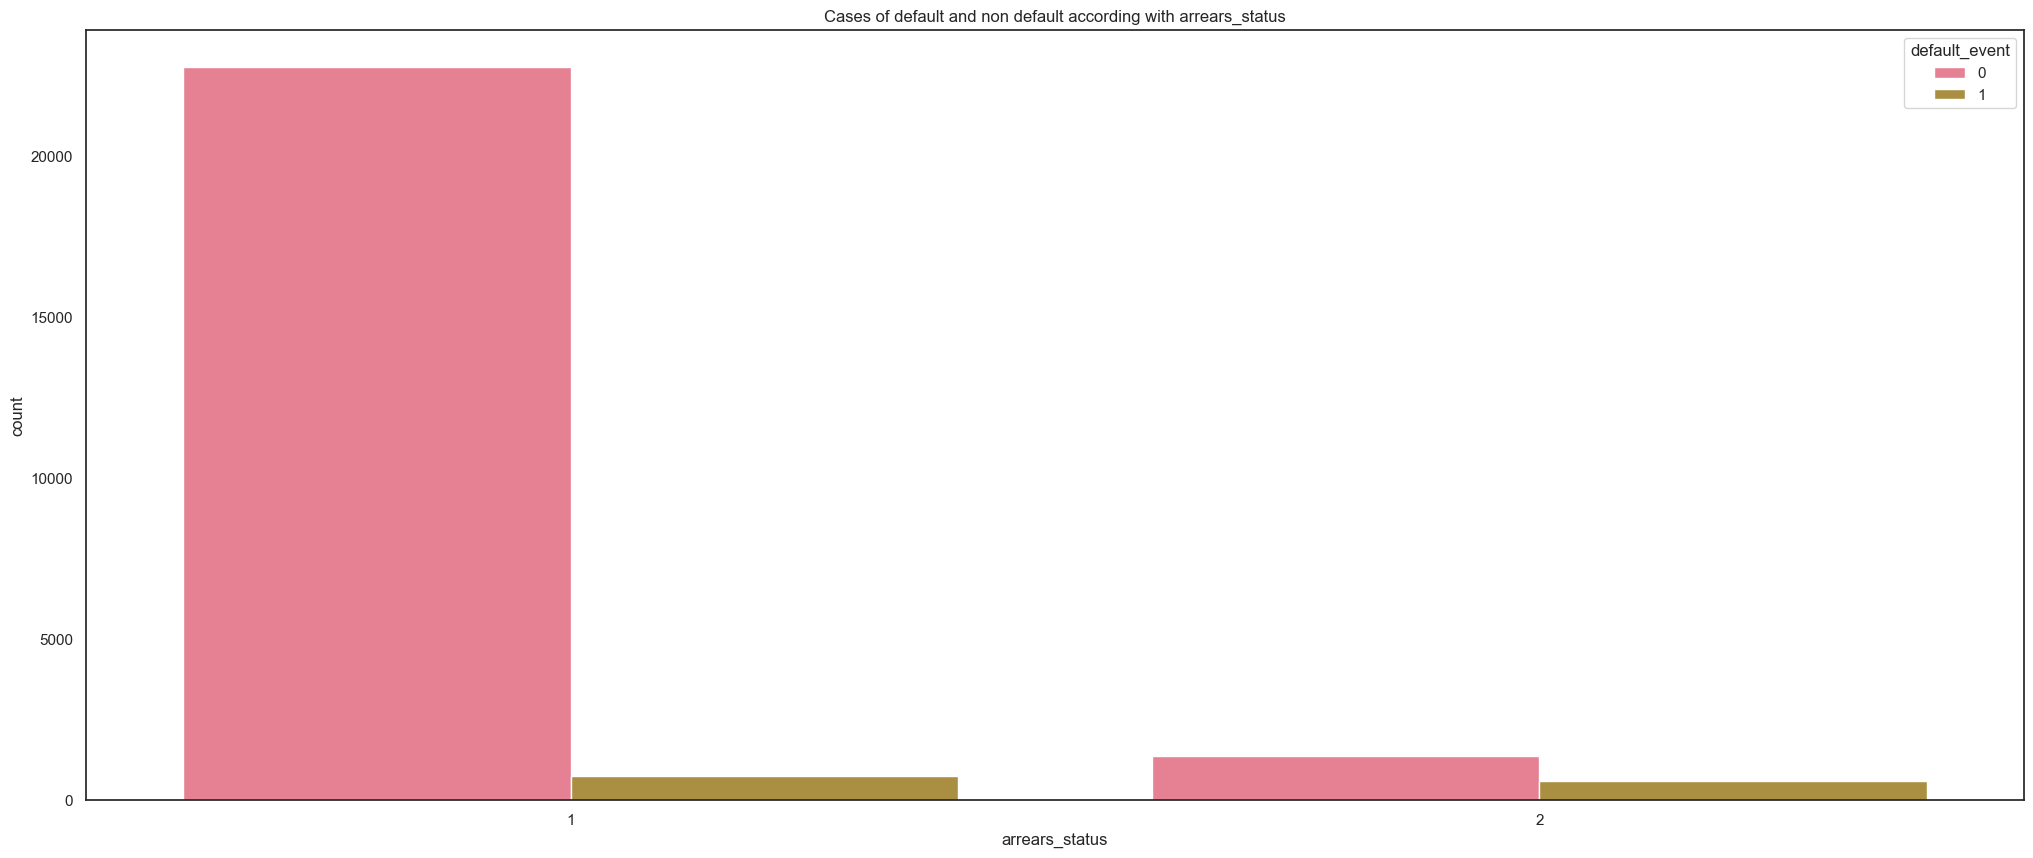

In [26]:
# Cases of default and non default , variable arrears_status
plt.figure(1,figsize = (25,10))
sns.countplot(hue = df2.default_event, x = df2.arrears_status)
plt.title('Cases of default and non default according with arrears_status')

## ok pl_flag, region, repayment_type

#'num_iva','pl_flag','region','repayment_type','arrears_status','arrears_segment',
#           'live_status','repaid_status','month','arrears_event','bankrupt_event','term_expiry_event','worst_arrears_status','avg_mia_6m',
#           'max_mia_6m','emp_length']

Text(0.5, 1.0, 'Cases of default and non default according with arrears_segment')

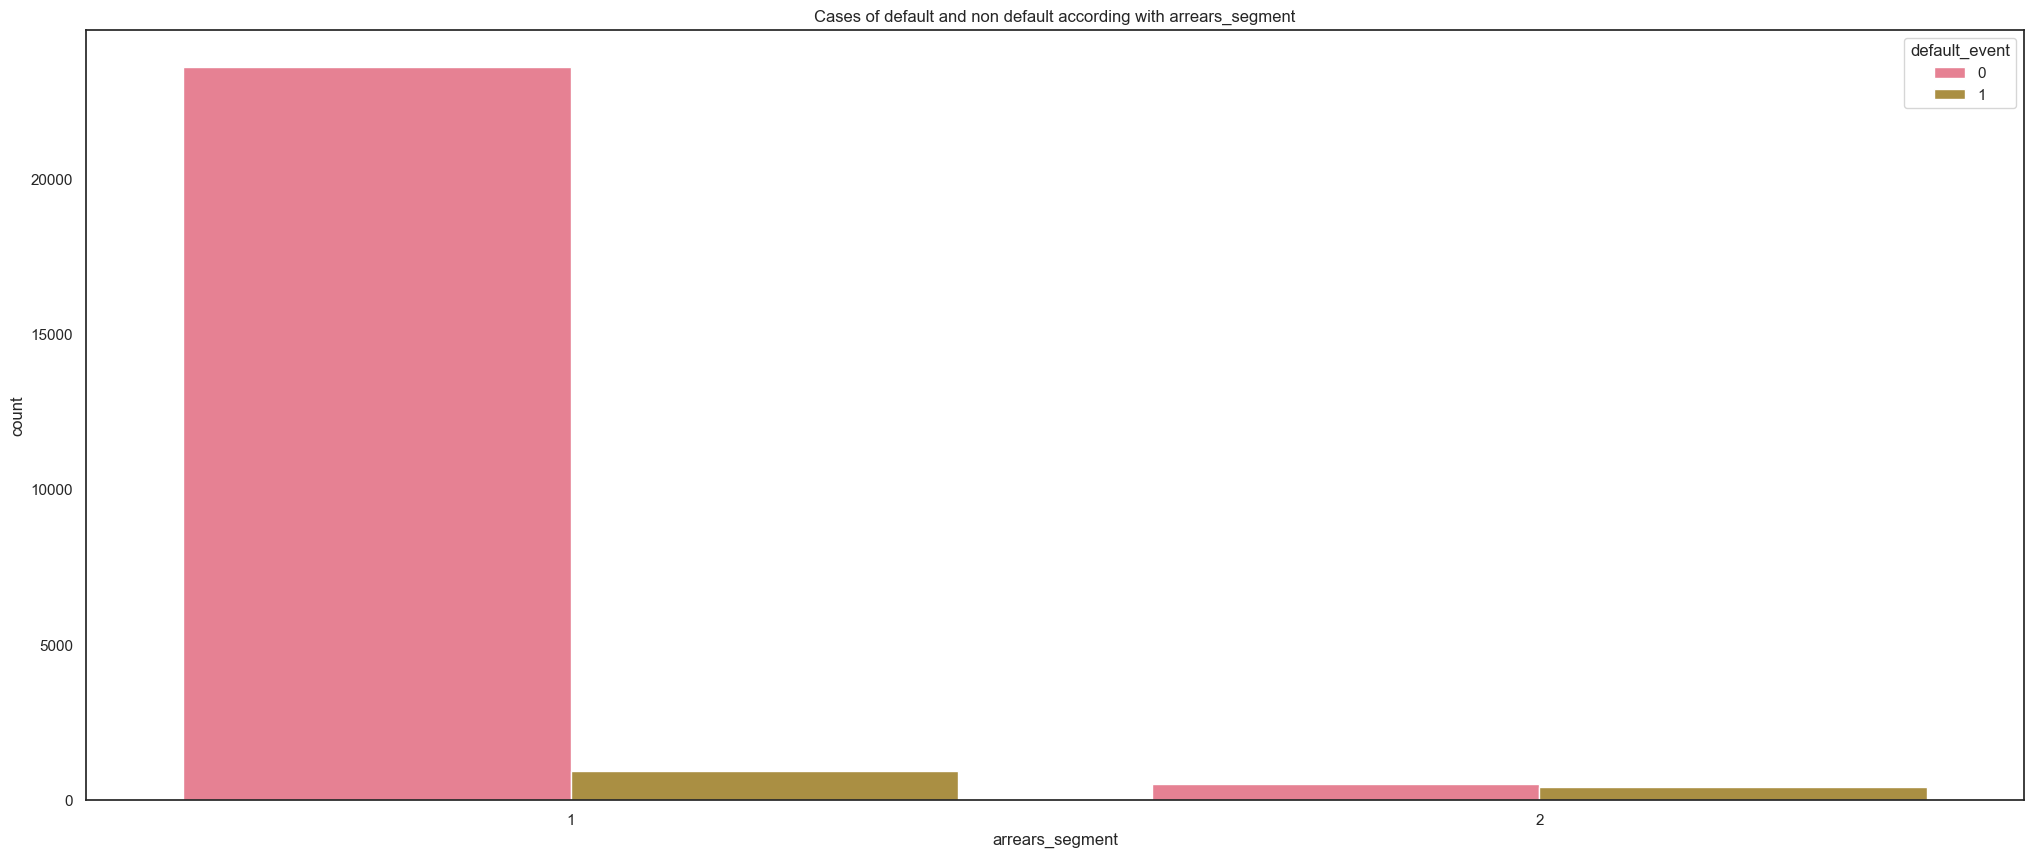

In [27]:
# Cases of default and non default , variable arrears_segment
plt.figure(1,figsize = (25,10))
sns.countplot(hue = df2.default_event, x = df2.arrears_segment)
plt.title('Cases of default and non default according with arrears_segment')

## ok pl_flag, region, repayment_type

#'num_iva','pl_flag','region','repayment_type','arrears_status','arrears_segment',
#           'live_status','repaid_status','month','arrears_event','bankrupt_event','term_expiry_event','worst_arrears_status','avg_mia_6m',
#           'max_mia_6m','emp_length']

Text(0.5, 1.0, 'Cases of default and non default according with live_status')

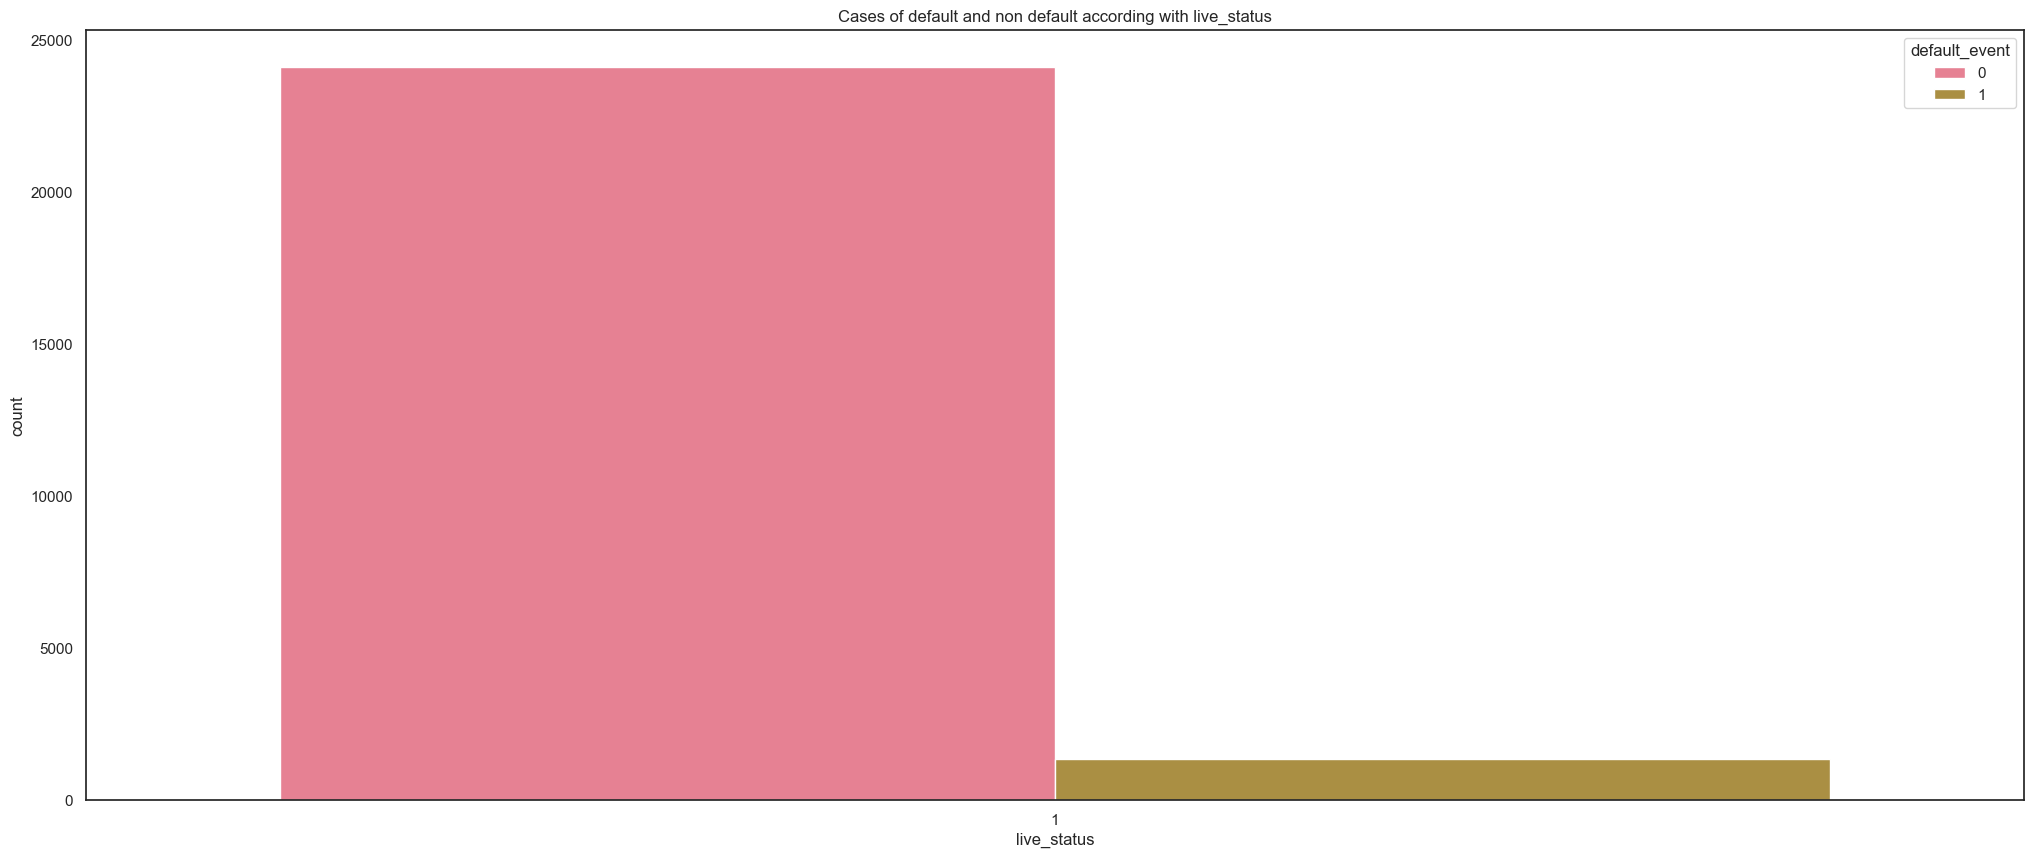

In [28]:
# Cases of default and non default , variable live_status
plt.figure(1,figsize = (25,10))
sns.countplot(hue = df2.default_event, x = df2.live_status)
plt.title('Cases of default and non default according with live_status')

## ok pl_flag, region, repayment_type

#'num_iva','pl_flag','region','repayment_type','arrears_status','arrears_segment',
#           'live_status','repaid_status','month','arrears_event','bankrupt_event','term_expiry_event','worst_arrears_status','avg_mia_6m',
#           'max_mia_6m','emp_length']

Text(0.5, 1.0, 'Cases of default and non default according with repaid_status')

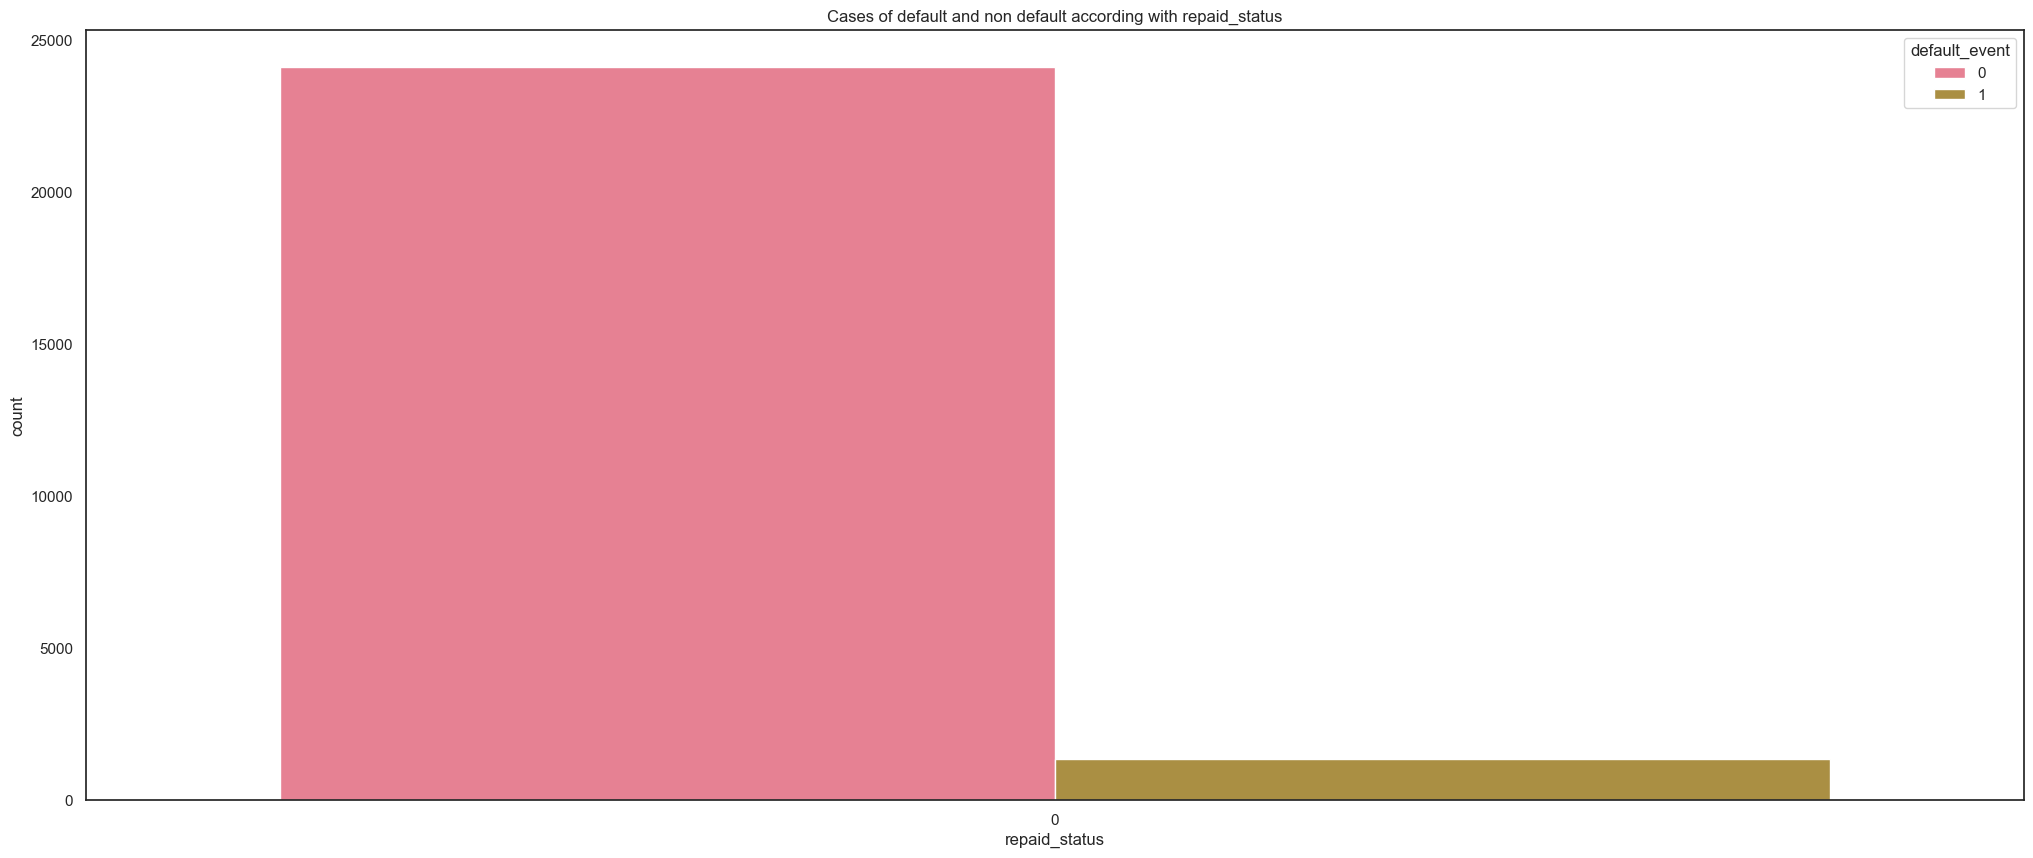

In [29]:
# Cases of default and non default , variable repaid_status
plt.figure(1,figsize = (25,10))
sns.countplot(hue = df2.default_event, x = df2.repaid_status)
plt.title('Cases of default and non default according with repaid_status')

## ok pl_flag, region, repayment_type

#'num_iva','pl_flag','region','repayment_type','arrears_status','arrears_segment',
#           'live_status','repaid_status','month','arrears_event','bankrupt_event','term_expiry_event','worst_arrears_status','avg_mia_6m',
#           'max_mia_6m','emp_length']

Text(0.5, 1.0, 'Cases of default and non default according with month')

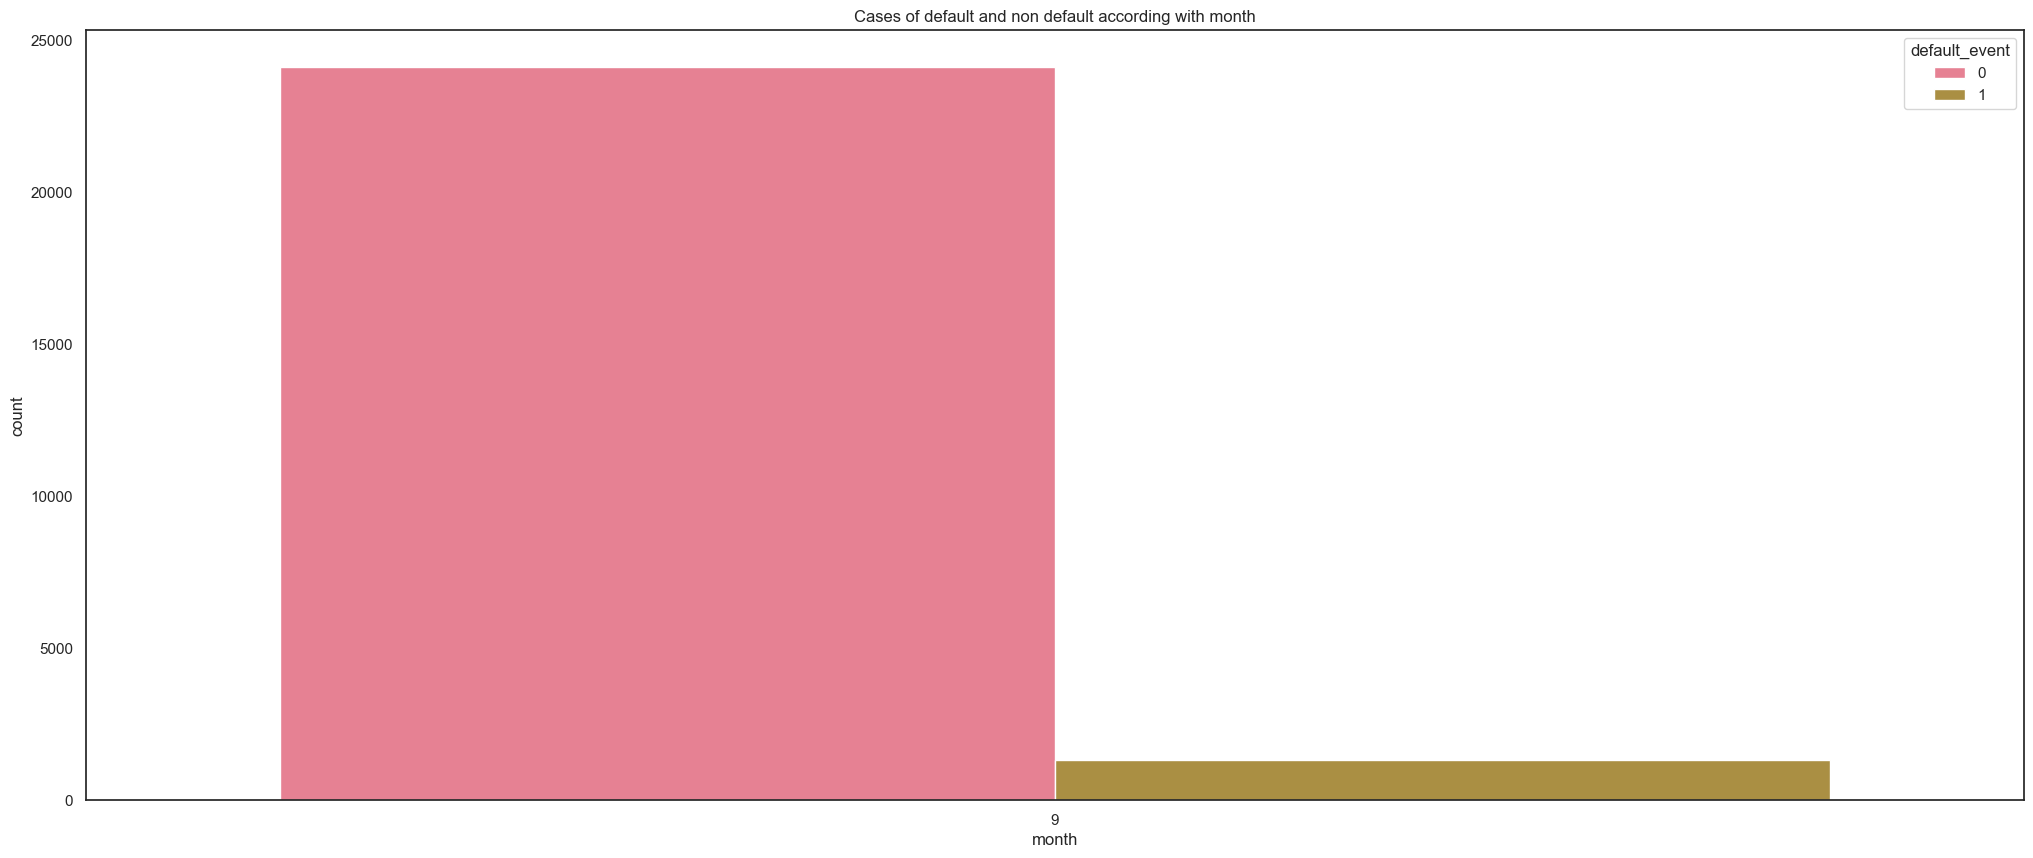

In [30]:
# Cases of default and non default , variable month
plt.figure(1,figsize = (25,10))
sns.countplot(hue = df2.default_event, x = df2.month)
plt.title('Cases of default and non default according with month')

## ok pl_flag, region, repayment_type

#'num_iva','pl_flag','region','repayment_type','arrears_status','arrears_segment',
#           'live_status','repaid_status','month','arrears_event','bankrupt_event','term_expiry_event','worst_arrears_status','avg_mia_6m',
#           'max_mia_6m','emp_length']

Text(0.5, 1.0, 'Cases of default and non default according with arrears_event')

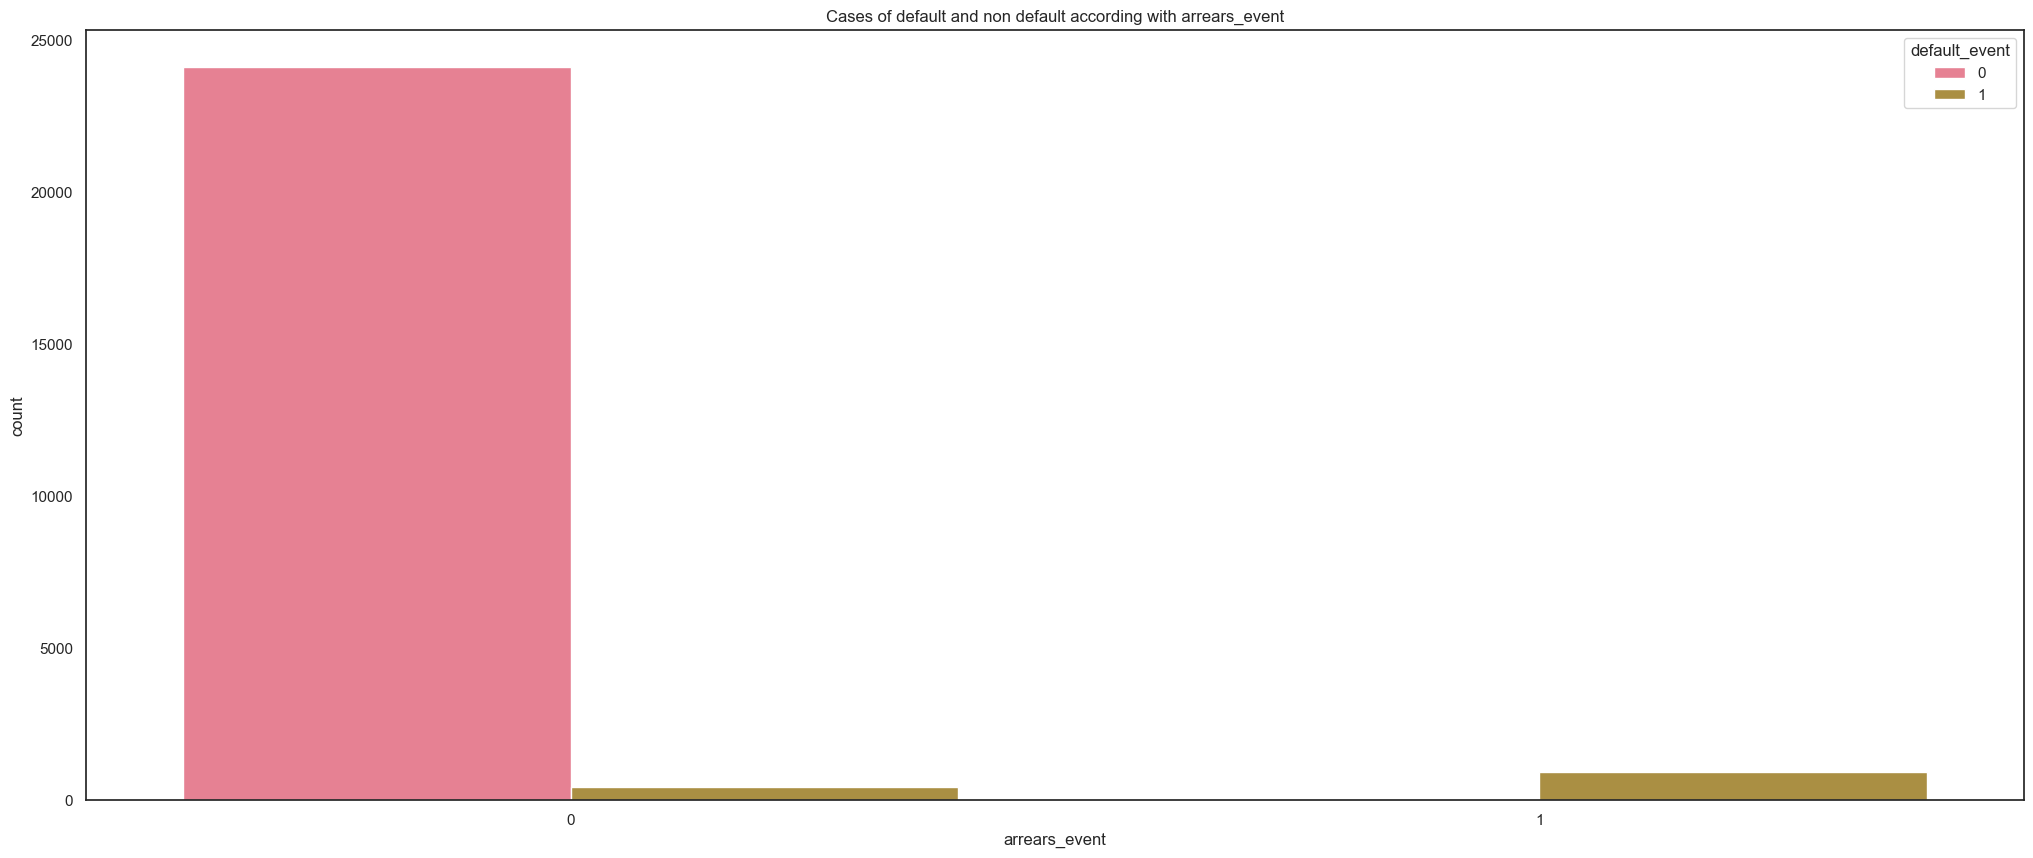

In [31]:
# Cases of default and non default , variable arrears_event
plt.figure(1,figsize = (25,10))
sns.countplot(hue = df2.default_event, x = df2.arrears_event)
plt.title('Cases of default and non default according with arrears_event')

## ok pl_flag, region, repayment_type

#'num_iva','pl_flag','region','repayment_type','arrears_status','arrears_segment',
#           'live_status','repaid_status','month','arrears_event','bankrupt_event','term_expiry_event','worst_arrears_status','avg_mia_6m',
#           'max_mia_6m','emp_length']

Text(0.5, 1.0, 'Cases of default and non default according with bankrupt_event')

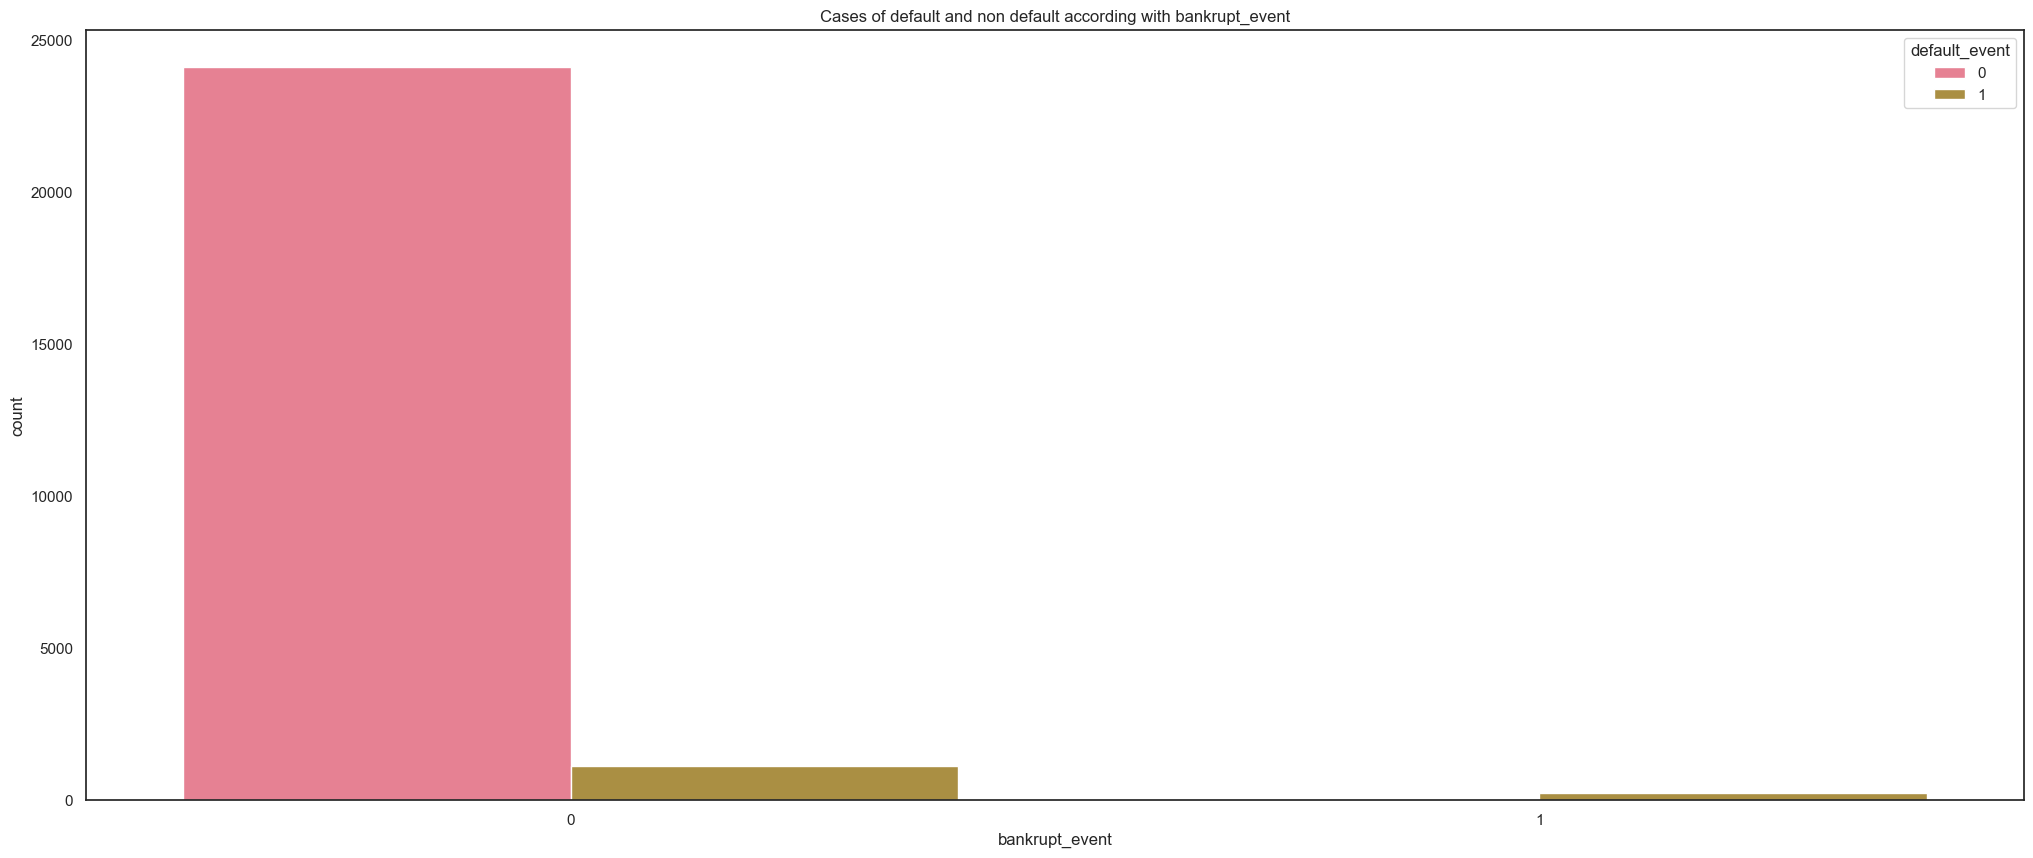

In [32]:
# Cases of default and non default , variable bankrupt_event
plt.figure(1,figsize = (25,10))
sns.countplot(hue = df2.default_event, x = df2.bankrupt_event)
plt.title('Cases of default and non default according with bankrupt_event')

## ok pl_flag, region, repayment_type

#'num_iva','pl_flag','region','repayment_type','arrears_status','arrears_segment',
#           'live_status','repaid_status','month','arrears_event','bankrupt_event','term_expiry_event','worst_arrears_status','avg_mia_6m',
#           'max_mia_6m','emp_length']

Text(0.5, 1.0, 'Cases of default and non default according with term_expiry_event')

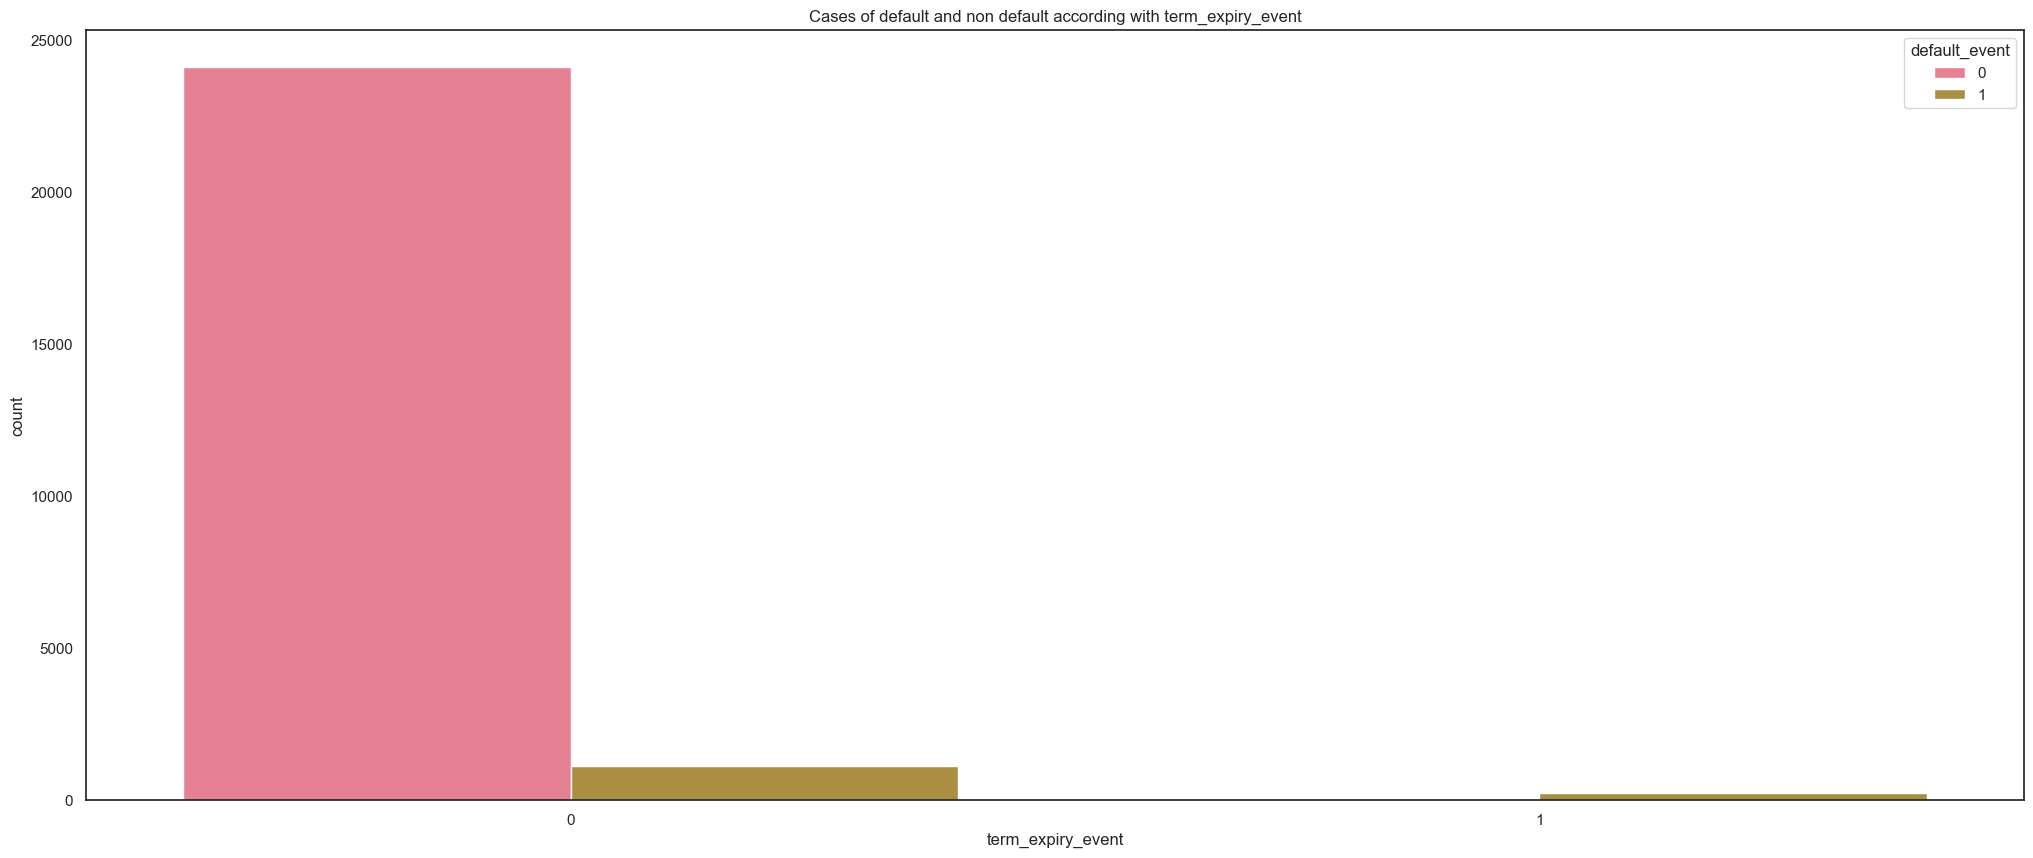

In [33]:
# Cases of default and non default , variable term_expiry_event
plt.figure(1,figsize = (25,10))
sns.countplot(hue = df2.default_event, x = df2.term_expiry_event)
plt.title('Cases of default and non default according with term_expiry_event')

## ok pl_flag, region, repayment_type

#'num_iva','pl_flag','region','repayment_type','arrears_status','arrears_segment',
#           'live_status','repaid_status','month','arrears_event','bankrupt_event','term_expiry_event','worst_arrears_status','avg_mia_6m',
#           'max_mia_6m','emp_length']

Text(0.5, 1.0, 'Cases of default and non default according with worst_arrears_status')

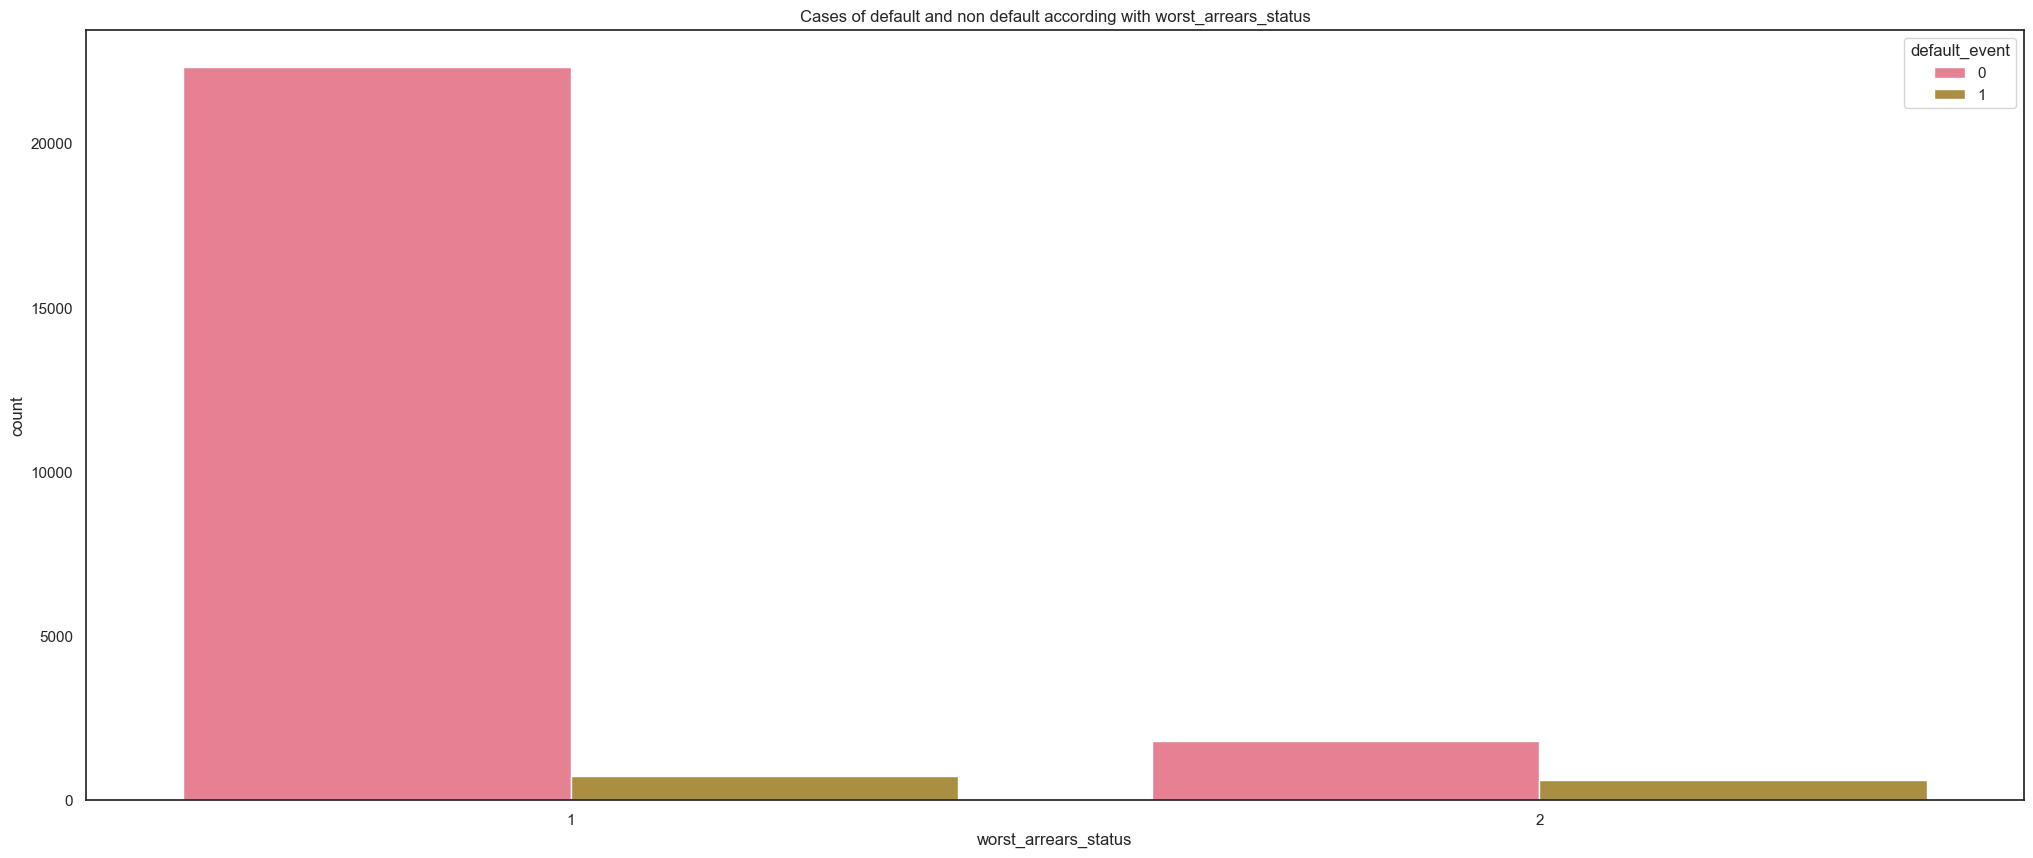

In [34]:
# Cases of default and non default , variable worst_arrears_status
plt.figure(1,figsize = (25,10))
sns.countplot(hue = df2.default_event, x = df2.worst_arrears_status)
plt.title('Cases of default and non default according with worst_arrears_status')

## ok pl_flag, region, repayment_type

#'num_iva','pl_flag','region','repayment_type','arrears_status','arrears_segment',
#           'live_status','repaid_status','month','arrears_event','bankrupt_event','term_expiry_event','worst_arrears_status','avg_mia_6m',
#           'max_mia_6m','emp_length']

Text(0.5, 1.0, 'Cases of default and non default according with avg_mia_6m')

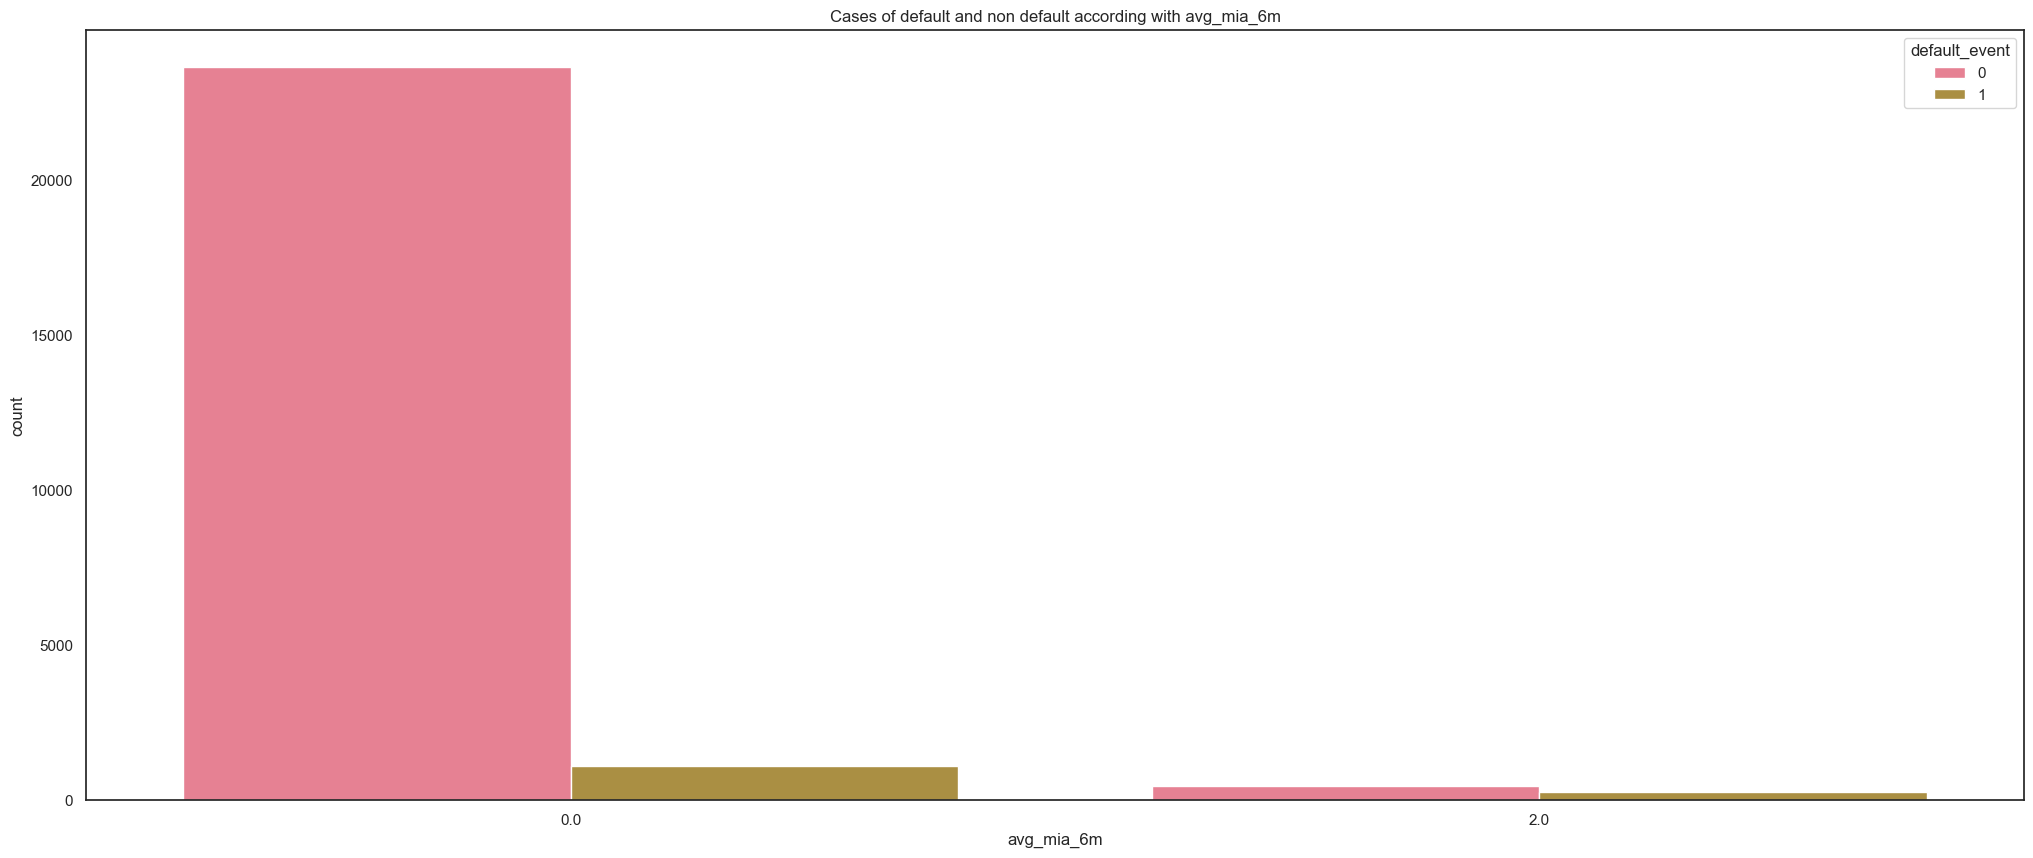

In [35]:
# Cases of default and non default , variable avg_mia_6m
plt.figure(1,figsize = (25,10))
sns.countplot(hue = df2.default_event, x = df2.avg_mia_6m)
plt.title('Cases of default and non default according with avg_mia_6m')

## ok pl_flag, region, repayment_type

#'num_iva','pl_flag','region','repayment_type','arrears_status','arrears_segment',
#           'live_status','repaid_status','month','arrears_event','bankrupt_event','term_expiry_event','worst_arrears_status','avg_mia_6m',
#           'max_mia_6m','emp_length']

Text(0.5, 1.0, 'Cases of default and non default according with max_mia_6m')

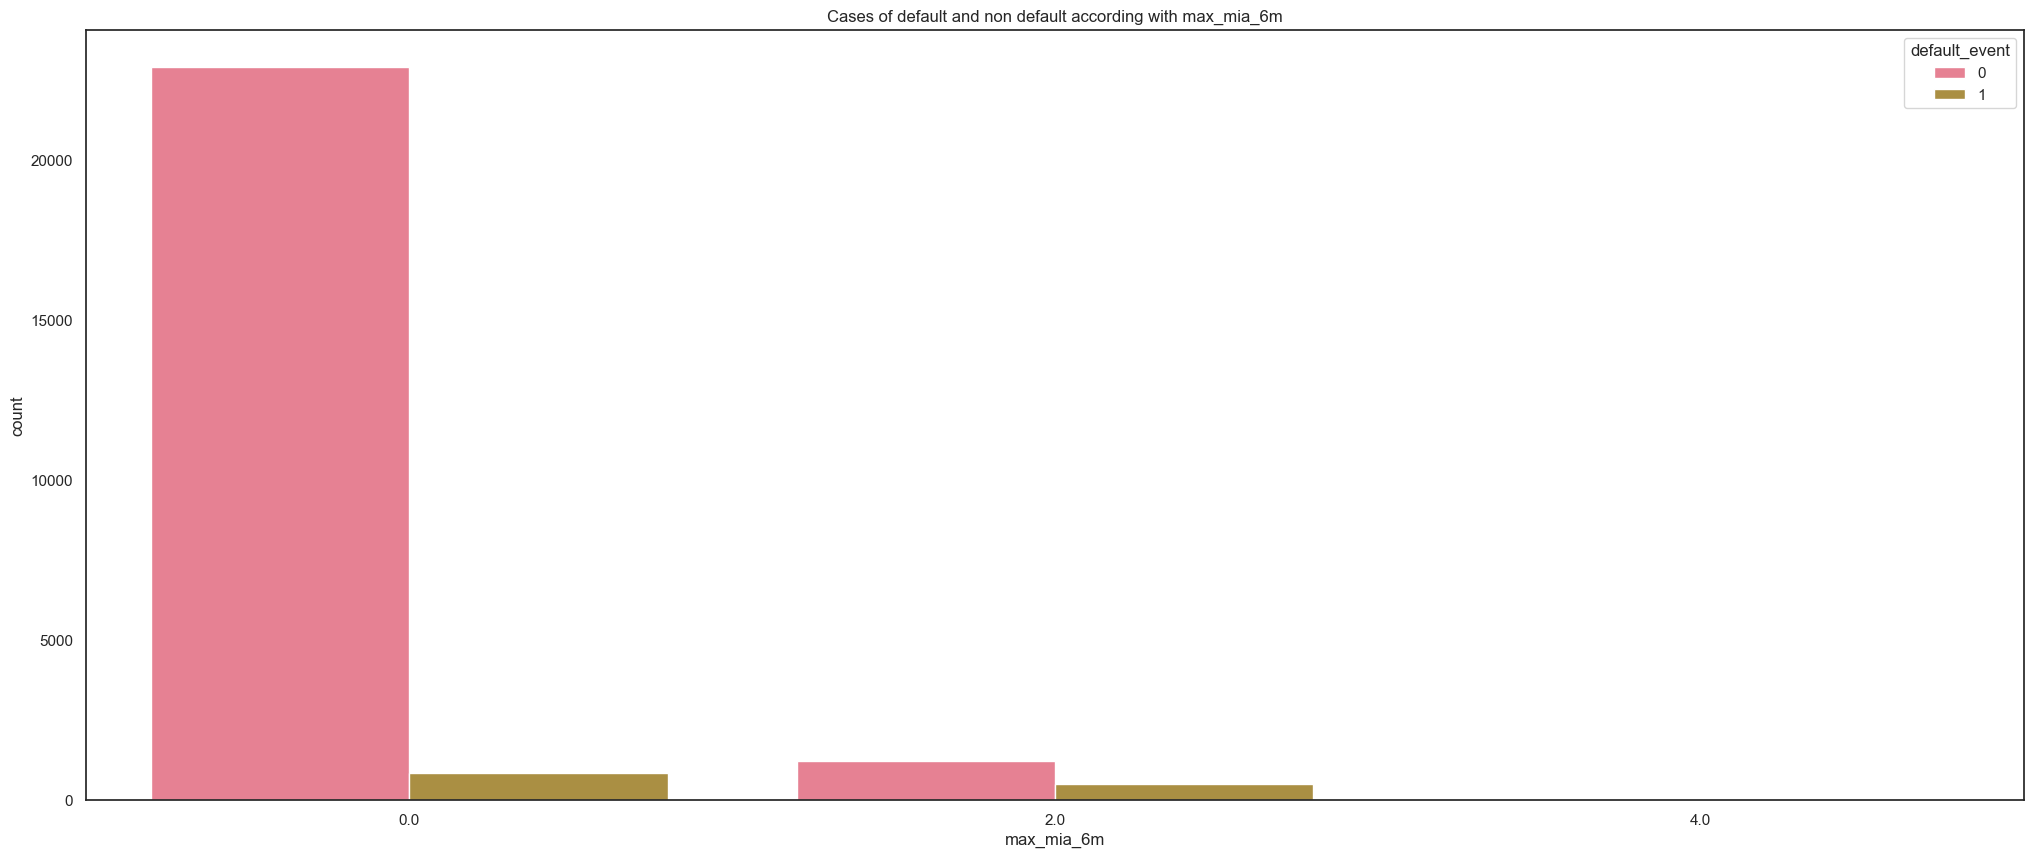

In [36]:
# Cases of default and non default , variable max_mia_6m
plt.figure(1,figsize = (25,10))
sns.countplot(hue = df2.default_event, x = df2.max_mia_6m)
plt.title('Cases of default and non default according with max_mia_6m')

## ok pl_flag, region, repayment_type

#'num_iva','pl_flag','region','repayment_type','arrears_status','arrears_segment',
#           'live_status','repaid_status','month','arrears_event','bankrupt_event','term_expiry_event','worst_arrears_status','avg_mia_6m',
#           'max_mia_6m','emp_length']

Text(0.5, 1.0, 'Cases of default and non default according with emp_length')

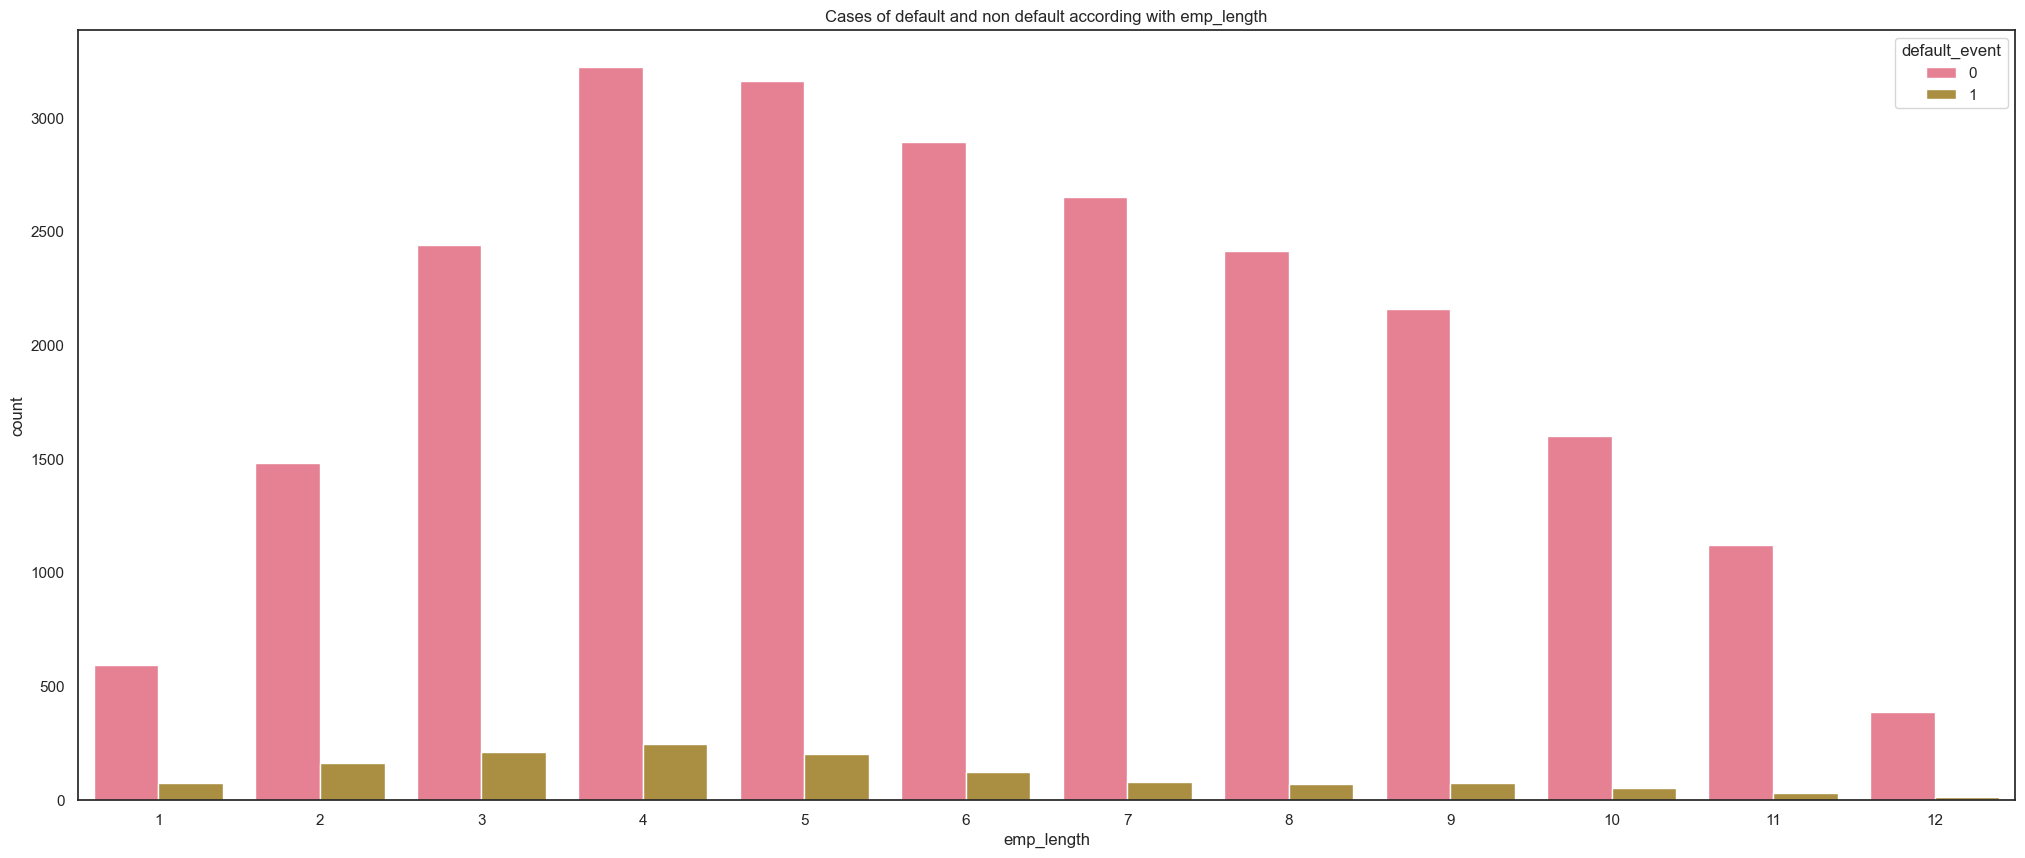

In [37]:
# Cases of default and non default , variable emp_length
plt.figure(1,figsize = (25,10))
sns.countplot(hue = df2.default_event, x = df2.emp_length)
plt.title('Cases of default and non default according with emp_length')

## ok pl_flag, region, repayment_type, emp_length

#'num_iva','pl_flag','region','repayment_type','arrears_status','arrears_segment',
#           'live_status','repaid_status','month','arrears_event','bankrupt_event','term_expiry_event','worst_arrears_status','avg_mia_6m',
#           'max_mia_6m','emp_length']

In [38]:
# Visualmente podemos considerar pl_flag, region, repayment_type, emp_length como las variables categoricas
# para entrar dentro del análisis

array([[<Axes: title={'center': 'monthly_installment'}>,
        <Axes: title={'center': 'loan_balance'}>,
        <Axes: title={'center': 'bureau_score'}>,
        <Axes: title={'center': 'time_since_bankrupt'}>],
       [<Axes: title={'center': 'time_since_ccj'}>,
        <Axes: title={'center': 'ccj_amount'}>,
        <Axes: title={'center': 'min_months_since_bankrupt'}>,
        <Axes: title={'center': 'ltv'}>],
       [<Axes: title={'center': 'arrears_months'}>,
        <Axes: title={'center': 'mob'}>,
        <Axes: title={'center': 'remaining_mat'}>,
        <Axes: title={'center': 'loan_term'}>],
       [<Axes: title={'center': 'max_arrears_12m'}>,
        <Axes: title={'center': 'max_arrears_bal_6m'}>,
        <Axes: title={'center': 'avg_bal_6m'}>,
        <Axes: title={'center': 'avg_bureau_score_6m'}>],
       [<Axes: title={'center': 'cc_util'}>,
        <Axes: title={'center': 'annual_income'}>,
        <Axes: title={'center': 'months_since_recent_cc_delinq'}>,
        <A

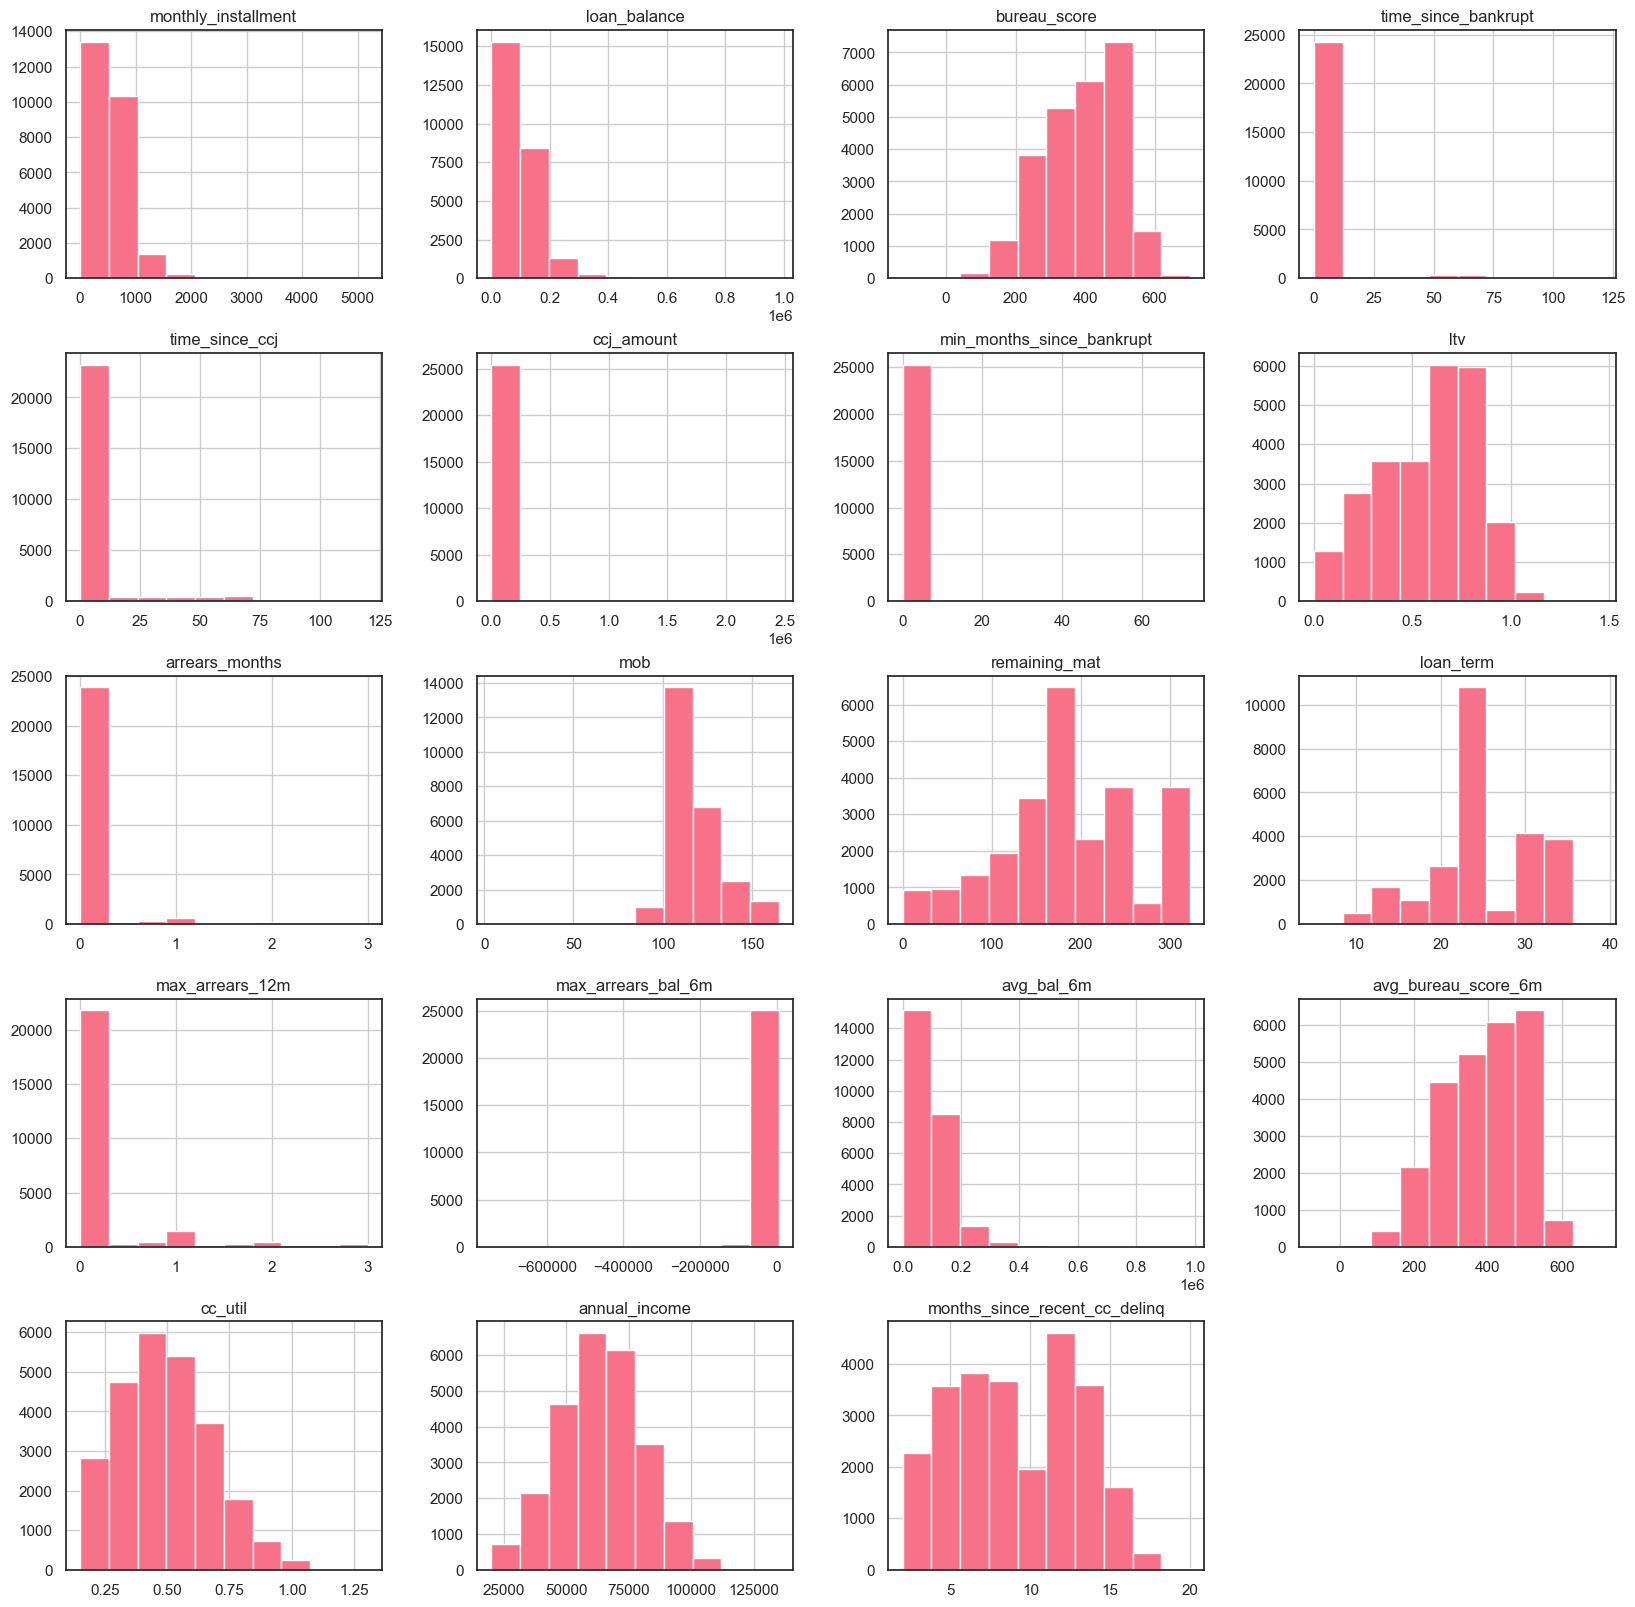

In [39]:
df2[var_con].hist(figsize = (20,20))

In [40]:
# df2['max_arrears_bal_6m'].hist(figsize = (15,15))

In [41]:
# Visualmente podemos considerar 
# 'monthly_installment','loan_balance','bureau_score',
# 'ltv','mob','remaining_mat','loan_term','avg_bal_6m','avg_bureau_score_6m',
# 'cc_util','annual_income','months_since_recent_cc_delinq'
# para entrar dentro del análisis

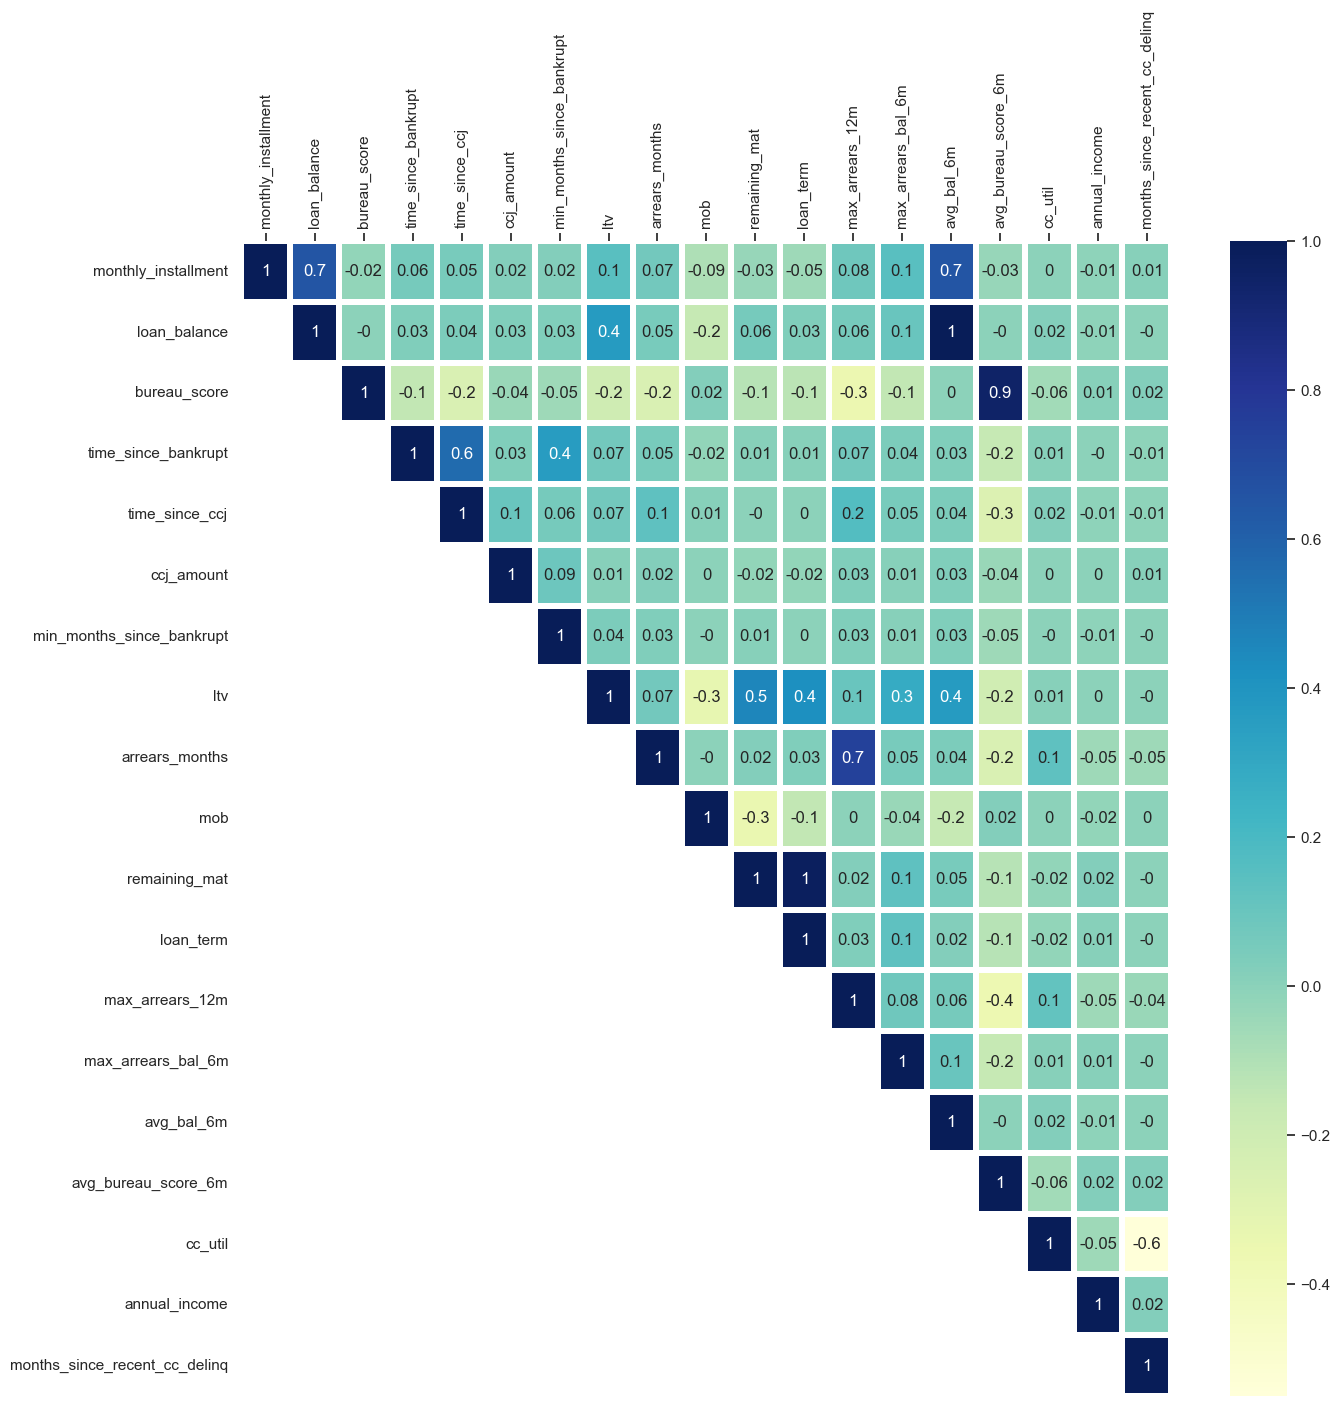

In [42]:
corr_df2_var_con = df2[var_con].corr()
mask = np.tri(corr_df2_var_con.shape[0],corr_df2_var_con.shape[1], k = -1)
plot_corr_up = plt.subplots(figsize = (15, 15))
plot_corr_up = sns.heatmap(round(corr_df2_var_con,2),mask = mask ,annot = True, cmap = 'YlGnBu', linewidths = 3, fmt = '.1g')
plot_corr_up.set(xlabel = "", ylabel = "")
plot_corr_up.xaxis.tick_top()
plot_corr_up.tick_params(axis = 'x', rotation = 90)

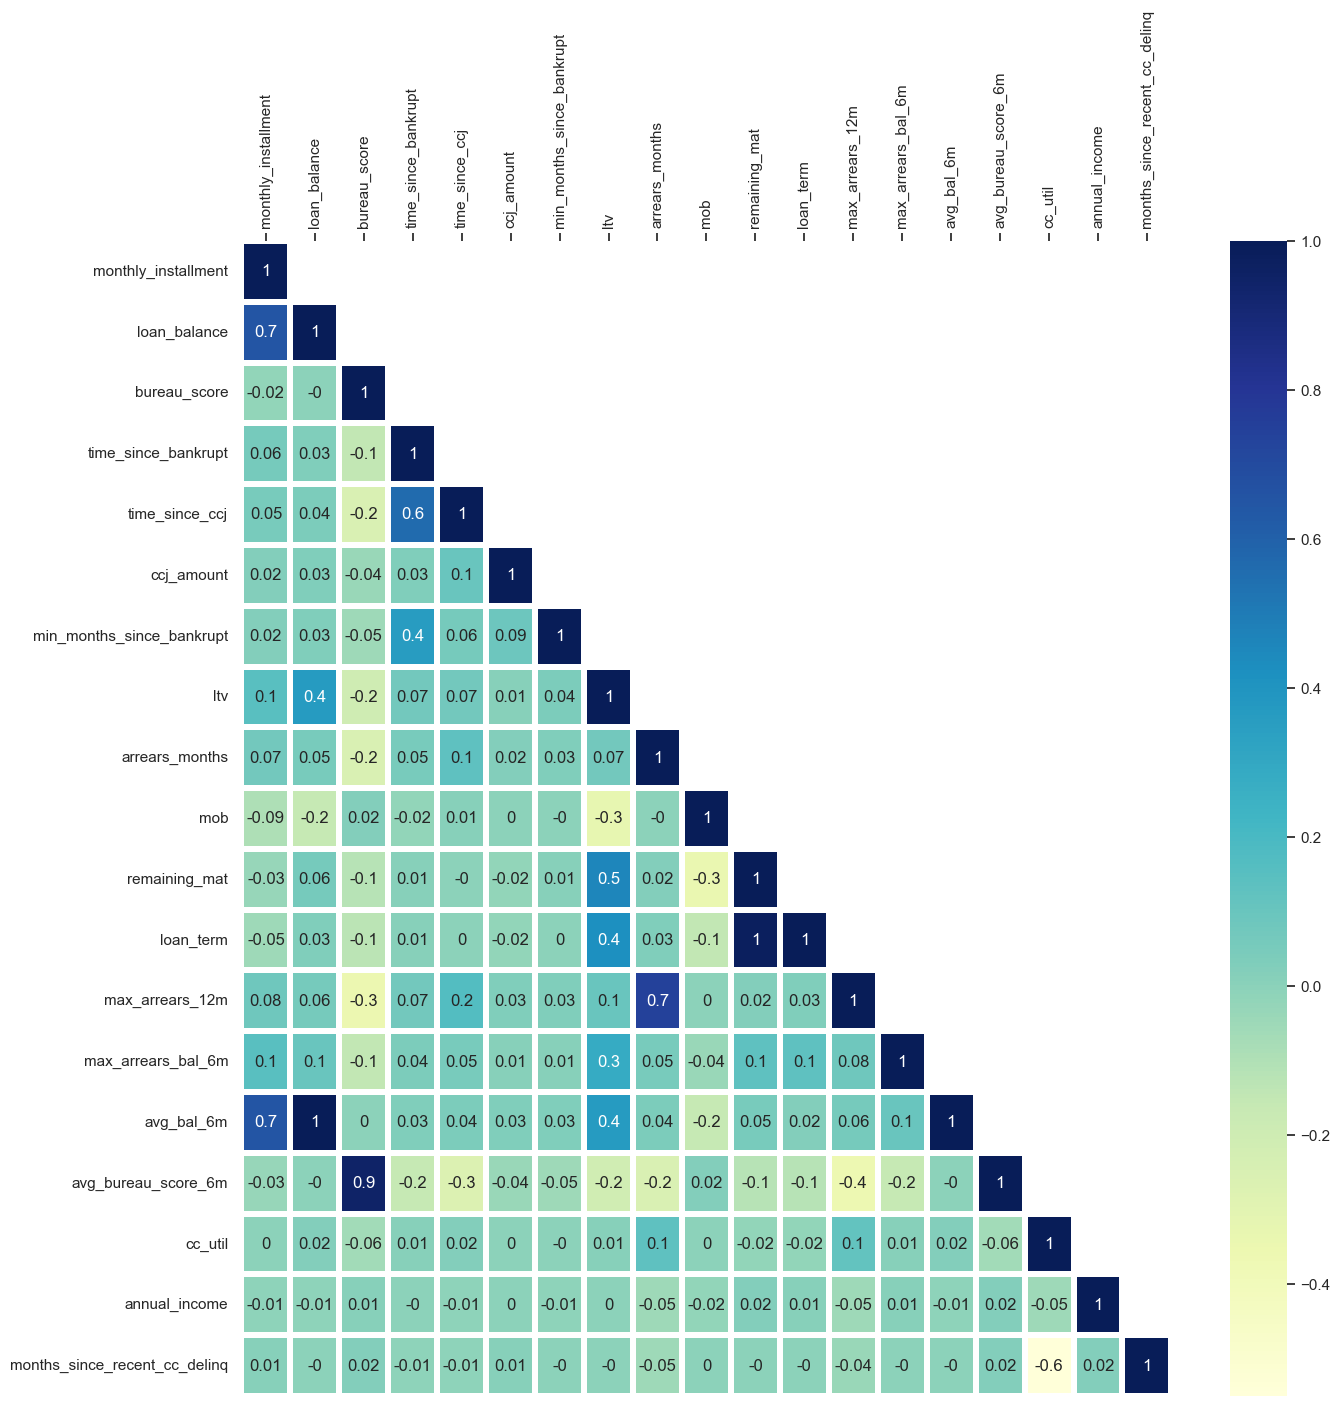

In [43]:
mask_lw = mask.T
plot_corr_lw = plt.subplots(figsize = (15, 15))
plot_corr_lw = sns.heatmap(round(corr_df2_var_con,2),mask = mask_lw ,annot = True, cmap = 'YlGnBu', linewidths = 3, fmt = '.1g')
plot_corr_lw.set(xlabel = "", ylabel = "")
plot_corr_lw.xaxis.tick_top()
plot_corr_lw.tick_params(axis = 'x', rotation = 90)

In [44]:
# Revisando la correlación, estás serían las posibles varieables a descartar
# annual income
# cc_util
# avg_bal_6m, está altamente correlacionada con monthly_atatement y loan _balance. Se elige loan_balance
# max_arrears_bal_6m
# loan_term
# remaining_mat
# min_months_since_bankrupt
# ccj_amount
# time_since_ccj

# En conclusion con la correlación y los histogramas podemos considerar 
# las siguientes variables para entrar dentro del análisis
# 'monthly_installment','loan_balance','bureau_score',
# 'ltv','mob','','','','avg_bureau_score_6m',
# '','annual_income','months_since_recent_cc_delinq'

var_con2 = ['monthly_installment','loan_balance','bureau_score','ltv','mob', 'avg_bureau_score_6m', 'annual_income', 'months_since_recent_cc_delinq' ]

#### 3.2 Identificación de variables unarias

In [45]:
# se sacan las variables : 
# var_cat no aplicables
# num_bankrupt
# num_bankrupt_iva
# num_iva
# arrears_status
# arrears_segment
# live_status
# repaid_status
# month
# arrears_event
# bannkrupt_event
# term_expiry_event
# avg_mia_6m
# max_mia_6m
# dentro de la lista de var_cat debido a que se consideran como variables unarias
# es decir; que la mayor parte de la información se concentra en 
# una categoría en particular

# las nuevas variables categoricas
var_cat = ['num_ccj','pl_flag','region','repayment_type','worst_arrears_status','emp_length']

##### Discretización de variables

In [46]:
from sklearn.preprocessing import KBinsDiscretizer

#### Función

In [47]:
def discretizar(df, v, k):

    kb = KBinsDiscretizer( n_bins = k , encode='ordinal', strategy = 'quantile')
    kb.fit(df[[v]])
    df[f'z_{v}_{k}'] = pd.cut( df[v] , bins = kb.bin_edges_[0] , include_lowest = True ).astype(str)

    return df

In [48]:
for v in var_con2:
    for k in range(2,6):
        df3 = discretizar( df2 , v , k )

In [49]:
df3.head()

,id,vintage_year,monthly_installment,loan_balance,bureau_score,num_bankrupt_iva,time_since_bankrupt,num_ccj,time_since_ccj,ccj_amount,...,z_avg_bureau_score_6m_4,z_avg_bureau_score_6m_5,z_annual_income_2,z_annual_income_3,z_annual_income_4,z_annual_income_5,z_months_since_recent_cc_delinq_2,z_months_since_recent_cc_delinq_3,z_months_since_recent_cc_delinq_4,z_months_since_recent_cc_delinq_5
0,6670001,2005,746.70,131304.44,541.0,0.0,0.0,0.0,0.0,0.0,...,"(482.0, 706.0]","(496.0, 706.0]","(63738.0, 135140.0]","(71121.0, 135140.0]","(75159.0, 135140.0]","(68045.0, 77900.6]","(9.0, 20.0]","(7.0, 11.0]","(9.0, 12.0]","(10.0, 13.0]"
1,9131199,2006,887.40,115486.51,441.0,0.0,0.0,0.0,0.0,0.0,...,"(482.0, 706.0]","(434.0, 496.0]","(63738.0, 135140.0]","(71121.0, 135140.0]","(75159.0, 135140.0]","(77900.6, 135140.0]","(1.999, 9.0]","(1.999, 7.0]","(6.0, 9.0]","(5.0, 8.0]"
2,4963167,2004,1008.50,128381.73,282.0,0.0,0.0,1.0,36.0,459.0,...,"(-70.001, 306.0]","(286.0, 366.0]","(20052.999, 63738.0]","(20052.999, 56448.0]","(20052.999, 52213.0]","(20052.999, 49384.8]","(1.999, 9.0]","(1.999, 7.0]","(1.999, 6.0]","(5.0, 8.0]"
3,3918582,2005,458.23,35482.96,461.0,0.0,0.0,0.0,0.0,0.0,...,"(402.0, 482.0]","(434.0, 496.0]","(20052.999, 63738.0]","(56448.0, 71121.0]","(52213.0, 63738.0]","(49384.8, 59461.0]","(1.999, 9.0]","(1.999, 7.0]","(1.999, 6.0]","(5.0, 8.0]"
4,5949777,2006,431.20,77086.31,466.0,0.0,0.0,0.0,0.0,0.0,...,"(402.0, 482.0]","(434.0, 496.0]","(63738.0, 135140.0]","(71121.0, 135140.0]","(75159.0, 135140.0]","(68045.0, 77900.6]","(1.999, 9.0]","(1.999, 7.0]","(1.999, 6.0]","(1.999, 5.0]"


In [50]:
var = df3.filter(like='z_').columns.to_list()

In [51]:
var

['z_monthly_installment_2',
 'z_monthly_installment_3',
 'z_monthly_installment_4',
 'z_monthly_installment_5',
 'z_loan_balance_2',
 'z_loan_balance_3',
 'z_loan_balance_4',
 'z_loan_balance_5',
 'z_bureau_score_2',
 'z_bureau_score_3',
 'z_bureau_score_4',
 'z_bureau_score_5',
 'z_ltv_2',
 'z_ltv_3',
 'z_ltv_4',
 'z_ltv_5',
 'z_mob_2',
 'z_mob_3',
 'z_mob_4',
 'z_mob_5',
 'z_avg_bureau_score_6m_2',
 'z_avg_bureau_score_6m_3',
 'z_avg_bureau_score_6m_4',
 'z_avg_bureau_score_6m_5',
 'z_annual_income_2',
 'z_annual_income_3',
 'z_annual_income_4',
 'z_annual_income_5',
 'z_months_since_recent_cc_delinq_2',
 'z_months_since_recent_cc_delinq_3',
 'z_months_since_recent_cc_delinq_4',
 'z_months_since_recent_cc_delinq_5']

#### 5.0 Análisis Univariado

#### 5.1 Information Value

#### Función

In [52]:
def calculo_iv( df, v, tgt ):
    aux = df.pivot_table( index = v, 
                         columns = tgt, 
                         values = um[0], 
                         aggfunc = 'count', 
                         fill_value = 0 )

    aux[list( range(2) ) ] = aux/aux.apply(np.sum)
    aux['w'] = np.log( aux[0] / aux[1] )
    aux['iv'] = (aux[0] - aux[1]) * aux['w']
    return v, aux['iv'].sum()

In [53]:
# iv de discretizadas -> vari
iv = pd.DataFrame( map( lambda v: calculo_iv( df3, v, tgt  ) , var ) , 
                  columns=['variable','IV'] )

In [54]:
iv['raiz'] = iv['variable'].map( lambda x: '_'.join(x.split('_')[1:2] ) )
iv = iv.sort_values(by = ['raiz','IV'],ascending=[1,0]).reset_index(drop=True)

# Eliminación de ivs infs
iv = iv.loc[iv['IV'] != np.inf].reset_index(drop=True)
iv['id'] = iv.groupby('raiz').cumcount() + 1
iv = iv.loc[iv.id == 1]

iv.drop(columns=['raiz','id'],inplace = True)

In [55]:
iv

,variable,IV
0,z_annual_income_5,0.409042
4,z_avg_bureau_score_6m_5,0.531387
8,z_bureau_score_5,0.532512
12,z_loan_balance_4,0.011856
16,z_ltv_4,0.022971
20,z_mob_3,0.014578
24,z_monthly_installment_5,0.012998
28,z_months_since_recent_cc_delinq_4,0.504738


In [56]:
var_best = iv['variable'].tolist()
len(var_best) , var_best

(8,
 ['z_annual_income_5',
  'z_avg_bureau_score_6m_5',
  'z_bureau_score_5',
  'z_loan_balance_4',
  'z_ltv_4',
  'z_mob_3',
  'z_monthly_installment_5',
  'z_months_since_recent_cc_delinq_4'])

In [57]:
iv['rankeo'] = iv.apply(lambda x: 0 if x['IV'] == 0 or x['IV'] == -1
                                else 1 if x['IV'] > 0 and x['IV'] <= 0.02  # 1st condition
                                else  2 if x['IV'] > 0.02 and x['IV'] <= 0.1 # 2nd condition
                                else 3 if x['IV'] > 0.1 and x['IV'] <= 0.3 # 3rd condition
                                else 4 if x['IV'] > 0.3 and x['IV'] <= 0.5 # 4rd condition
                                else 5 if x['IV'] > 0.5 # 5rd condition 
                                else np.nan,axis = 1)

In [58]:
iv

,variable,IV,rankeo
0,z_annual_income_5,0.409042,4
4,z_avg_bureau_score_6m_5,0.531387,5
8,z_bureau_score_5,0.532512,5
12,z_loan_balance_4,0.011856,1
16,z_ltv_4,0.022971,2
20,z_mob_3,0.014578,1
24,z_monthly_installment_5,0.012998,1
28,z_months_since_recent_cc_delinq_4,0.504738,5


In [59]:
iv.sort_values(by='rankeo',ascending = False)

,variable,IV,rankeo
4,z_avg_bureau_score_6m_5,0.531387,5
8,z_bureau_score_5,0.532512,5
28,z_months_since_recent_cc_delinq_4,0.504738,5
0,z_annual_income_5,0.409042,4
16,z_ltv_4,0.022971,2
12,z_loan_balance_4,0.011856,1
20,z_mob_3,0.014578,1
24,z_monthly_installment_5,0.012998,1


In [60]:
var_best2 = iv['variable'].loc[iv.loc[:, 'rankeo'] >= 4].tolist()

In [61]:
var_best2

['z_annual_income_5',
 'z_avg_bureau_score_6m_5',
 'z_bureau_score_5',
 'z_months_since_recent_cc_delinq_4']

In [66]:
from optbinning import BinningProcess, OptimalBinning

KeyboardInterrupt: 

In [63]:
# Getting IV value for numerical variables 
iv_list_con = []

for val in var_best:

    x = df3[val].values
    y = df2['default_event'].values
    optb = OptimalBinning(name = val, dtype = 'numerical', solver = 'cp')
    optb.fit(x, y)
    binning_table = optb.binning_table
    iv_list_con.append(binning_table.build().loc['Totals', 'IV'])

ValueError: could not convert string to float: '(68045.0, 77900.6]'

#### Partición de los datos

In [92]:
# creación del split
from sklearn.model_selection import train_test_split

X = df3[var_best + um ].copy() # var_best
#Y = df2[tgt + ['id']].copy()
Y = df3[um + tgt].copy()

Xt, Xv, Yt, Yv = train_test_split(X, Y, test_size=.3)

Xt = Xt.merge( Yt , on = um, how = 'inner').reset_index(drop = True)

In [93]:
Xt.shape, Xv.shape, Yt.shape[0], Yv.shape[0]

((17825, 10), (7640, 9), 17825, 7640)

#### Transformación WoE

#### Codificación WoE

In [64]:
def codificacion_woe(df, v, tgt):
    aux = df.pivot_table( index = v,
                          columns = tgt,
                          values = um[0],
                          aggfunc = 'count',
                          fill_value = 0)

    aux[list( range(2) )] = aux / aux.apply(np.sum)

    aux['w'] = np.log( aux[0] / aux[1] )

    aux.drop(range(2) , axis=1 , inplace=True )

    aux = aux.to_dict()['w']
    
    return v, aux

In [65]:
# inside of the table X must be the target
mapa_woe = list( map(  lambda v: codificacion_woe( Xt , v , tgt  ) , var_best  ) )


In [66]:
# inside of the table X must be the target
mapa_woe2 = list( map(  lambda v: codificacion_woe( Xt , v , tgt  ) , var_best2  ) )

In [94]:
mapa_woe

[('z_annual_income_5',
  {'(20052.999, 49384.8]': -0.9483609486615668,
   '(49384.8, 59461.0]': 0.23177343518206908,
   '(59461.0, 68045.0]': 0.4196510547853273,
   '(68045.0, 77900.6]': 0.7095840246200537,
   '(77900.6, 135140.0]': 0.46076277841089763}),
 ('z_avg_bureau_score_6m_5',
  {'(-70.001, 286.0]': -0.8896022619982641,
   '(286.0, 366.0]': -0.19590282444429347,
   '(366.0, 434.0]': 0.41528058314575694,
   '(434.0, 496.0]': 0.9044973793634093,
   '(496.0, 706.0]': 0.9881041355518358}),
 ('z_bureau_score_5',
  {'(-125.001, 287.0]': -0.8967864253352323,
   '(287.0, 367.0]': -0.21327252081182418,
   '(367.0, 437.0]': 0.40659899009887834,
   '(437.0, 497.0]': 0.960109895893004,
   '(497.0, 702.0]': 0.969602272648066}),
 ('z_loan_balance_4',
  {'(0.199, 59034.9]': 0.1521783840100644,
   '(123679.06, 983843.66]': -0.15257187423627577,
   '(59034.9, 85446.08]': 0.06345527663649182,
   '(85446.08, 123679.06]': -0.040141267629626304}),
 ('z_ltv_4',
  {'(-0.0009, 0.391]': 0.12983034558136

In [68]:
mapa_woe2

[('z_annual_income_5',
  {'(20052.999, 49384.8]': -0.9267898510228978,
   '(49384.8, 59461.0]': 0.13973824006125052,
   '(59461.0, 68045.0]': 0.4723436887784947,
   '(68045.0, 77900.6]': 0.6867606859554454,
   '(77900.6, 135140.0]': 0.4782434109056829}),
 ('z_avg_bureau_score_6m_5',
  {'(-70.001, 286.0]': -0.8931336754570949,
   '(286.0, 366.0]': -0.21937800615985018,
   '(366.0, 434.0]': 0.39176115073400875,
   '(434.0, 496.0]': 0.8607990628597856,
   '(496.0, 706.0]': 1.0981262023792988}),
 ('z_bureau_score_5',
  {'(-125.001, 287.0]': -0.8908352293584836,
   '(287.0, 367.0]': -0.23248235213391977,
   '(367.0, 437.0]': 0.3471883025865343,
   '(437.0, 497.0]': 0.9377211072223184,
   '(497.0, 702.0]': 1.0569082149176134}),
 ('z_months_since_recent_cc_delinq_4',
  {'(1.999, 6.0]': -0.43123568754444275,
   '(12.0, 20.0]': 1.9845479836805453,
   '(6.0, 9.0]': -0.3526782408362317,
   '(9.0, 12.0]': 0.2288054868805773})]

In [95]:
for v, mapa in mapa_woe:
    Xt[f'w_{v}'] = Xt[v].replace(mapa)
    Xv[f'w_{v}'] = Xv[v].replace(mapa)

In [70]:
for v, mapa in mapa_woe2:
    Xt[f'w_{v}'] = Xt[v].replace(mapa)
    Xv[f'w_{v}'] = Xv[v].replace(mapa)

In [96]:
varw = Xt.filter(like='w_').columns.tolist()

In [97]:
varw

['w_z_annual_income_5',
 'w_z_avg_bureau_score_6m_5',
 'w_z_bureau_score_5',
 'w_z_loan_balance_4',
 'w_z_ltv_4',
 'w_z_mob_3',
 'w_z_monthly_installment_5',
 'w_z_months_since_recent_cc_delinq_4']

In [73]:
from sklearn.feature_selection import SequentialFeatureSelector

In [74]:
from sklearn import linear_model

In [75]:
# Perform stepwise regression
sfs = SequentialFeatureSelector(linear_model.LogisticRegression(),
                                n_features_to_select = 3,
                                direction = 'forward',
                                scoring = 'accuracy',
                                cv = None)

In [76]:
Yt_tgt = Yt[tgt]
Yv_tgt = Yv[tgt]

In [98]:
selected_features = sfs.fit(Xt[varw], Yt_tgt)

c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1408: D

In [99]:
features = selected_features.get_support()

In [100]:
# solo se puede hacer si la con la tabla que tengas las mismas columnas 
features = Xt[varw].columns[features].tolist()

In [101]:
features

['w_z_annual_income_5', 'w_z_avg_bureau_score_6m_5', 'w_z_bureau_score_5']

#### TAD

In [102]:
tad = Xt[ um + features  ].merge( Yt , on = um , how ='inner'  )

In [103]:
tad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17825 entries, 0 to 17824
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         17825 non-null  int64  
 1   w_z_annual_income_5        17825 non-null  float64
 2   w_z_avg_bureau_score_6m_5  17825 non-null  float64
 3   w_z_bureau_score_5         17825 non-null  float64
 4   default_event              17825 non-null  int32  
dtypes: float64(3), int32(1), int64(1)
memory usage: 626.8 KB


In [104]:
tad.head()

,id,w_z_annual_income_5,w_z_avg_bureau_score_6m_5,w_z_bureau_score_5,default_event
0,3185227,0.709584,0.415281,0.406599,0
1,4651796,0.419651,0.904497,0.406599,0
2,4880172,0.460763,0.415281,0.406599,0
3,2895516,-0.948361,0.904497,0.406599,0
4,4300412,0.419651,0.904497,0.406599,0


#### Modelo

In [105]:
from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix
from sklearn.linear_model import LogisticRegression

In [106]:
mlog_reg = LogisticRegression()

In [107]:
mlog_reg.fit( Xt[features] , Yt[tgt] )

c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [108]:
pd.DataFrame(mlog_reg.predict_proba(Xv[features]))

,0,1
0,0.952851,0.047149
1,0.965703,0.034297
2,0.981936,0.018064
3,0.930986,0.069014
4,0.989572,0.010428
...,...,...
7635,0.960980,0.039020
7636,0.956820,0.043180
7637,0.934644,0.065356
7638,0.983580,0.016420


#### Evaluación

In [109]:
from scikitplot.metrics import plot_roc_curve
from sklearn.metrics import classification_report

c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:95: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:95: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

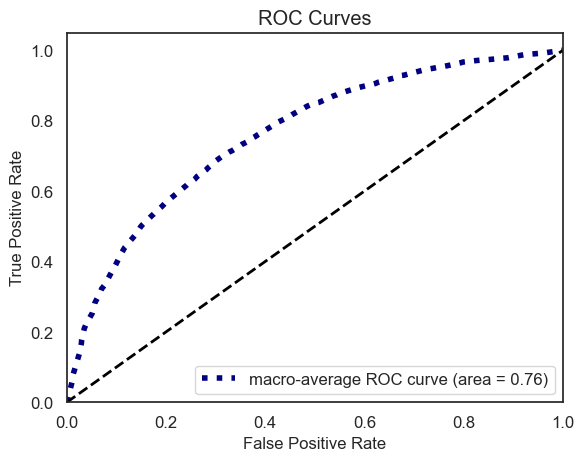

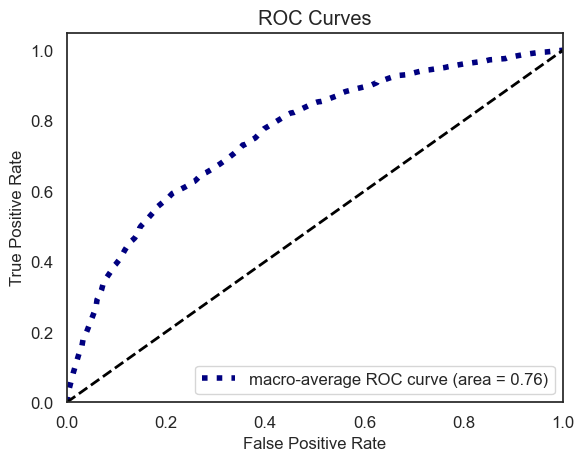

In [110]:
plot_roc_curve( y_true = Yt[tgt] , y_probas = mlog_reg.predict_proba( Xt[features] ) , curves = 'macro' )
plot_roc_curve( y_true = Yv[tgt] , y_probas = mlog_reg.predict_proba( Xv[features] ) , curves = 'macro' )

In [111]:
# es el mean accuracy
mlog_reg.score(Xt[features],Yt[tgt])

0.9472089761570828

In [112]:
# Realizamos la evaluación de nuestro modelo:
print('Entrenamiento: \n')
predictions_t = mlog_reg.predict(Xt[features])
print(classification_report(Yt_tgt, predictions_t))
print('Matriz: \n')
print(confusion_matrix(Yt_tgt, predictions_t))
print('Validación: \n')
predictions_v = mlog_reg.predict(Xv[features])
print(classification_report(Yv_tgt, predictions_v))
print('Matriz: \n')
print(confusion_matrix(Yv_tgt, predictions_v))

Entrenamiento: 

              precision    recall  f1-score   support

           0       0.95      1.00      0.97     16894
           1       0.00      0.00      0.00       931

    accuracy                           0.95     17825
   macro avg       0.47      0.50      0.49     17825
weighted avg       0.90      0.95      0.92     17825

Matriz: 

[[16894     0]
 [  931     0]]
Validación: 

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      7235
           1       0.00      0.00      0.00       405

    accuracy                           0.95      7640
   macro avg       0.47      0.50      0.49      7640
weighted avg       0.90      0.95      0.92      7640

Matriz: 

[[7235    0]
 [ 405    0]]


c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [113]:
Xt2 = Xt[features]
Xv2 = Xv[features]

In [114]:
Xt2.shape, Xv2.shape, 

((17825, 3), (7640, 3))

In [115]:
mlog_reg.coef_

array([[-0.96282942, -0.53360567, -0.53503005]])

In [116]:
mlog_reg.intercept_

array([-2.87323784])

In [117]:
coeficients = pd.DataFrame(zip(Xv[features].columns, np.transpose(mlog_reg.coef_)), columns=['features', 'coef']) 

In [118]:
coeficients['coef'] = coeficients['coef'].astype(float)
coeficients['features'] = coeficients['features'].astype(str)

In [119]:
coeficients.head()

,features,coef
0,w_z_annual_income_5,-0.962829
1,w_z_avg_bureau_score_6m_5,-0.533606
2,w_z_bureau_score_5,-0.535030


In [120]:
coeficients.loc[coeficients.features == 'w_z_annual_income_5', 'coef']

0   -0.962829
Name: coef, dtype: float64

In [126]:
# valor de los coeficientes
v_w_z_annual_income_5 = coeficients.loc[coeficients.features == 'w_z_annual_income_5', 'coef']
v_w_z_avg_bureau_score_6m_5 = coeficients.loc[coeficients.features == 'w_z_avg_bureau_score_6m_5', 'coef']
v_w_z_bureau_score_5 = coeficients.loc[coeficients.features == 'w_z_bureau_score_5', 'coef']

In [127]:
Xt2['c_w_z_annual_income_5'] = pd.Series([v_w_z_annual_income_5.values for x in range(len(Xt2.index))])
Xt2['c_w_z_avg_bureau_score_6m_5'] = pd.Series([v_w_z_avg_bureau_score_6m_5.values for x in range(len(Xt2.index))])
Xt2['c_w_z_bureau_score_5'] = pd.Series([v_w_z_bureau_score_5.values for x in range(len(Xt2.index))])
#Xt2['c_w_z_annual_income_5'] =  v_w_z_annual_income_5 

C:\Users\Daniel\AppData\Local\Temp\ipykernel_13156\2187225543.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xt2['c_w_z_annual_income_5'] = pd.Series([v_w_z_annual_income_5.values for x in range(len(Xt2.index))])
C:\Users\Daniel\AppData\Local\Temp\ipykernel_13156\2187225543.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xt2['c_w_z_avg_bureau_score_6m_5'] = pd.Series([v_w_z_avg_bureau_score_6m_5.values for x in range(len(Xt2.index))])
C:\Users\Daniel\AppData\Local\Temp\ipykernel_13156\2187225543.py

In [128]:
Xt2['c_w_z_annual_income_5'] = Xt2['c_w_z_annual_income_5'].astype(float)
Xt2['c_w_z_avg_bureau_score_6m_5'] = Xt2['c_w_z_avg_bureau_score_6m_5'].astype(float)
Xt2['c_w_z_bureau_score_5'] = Xt2['c_w_z_bureau_score_5'].astype(float)

C:\Users\Daniel\AppData\Local\Temp\ipykernel_13156\4191208612.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xt2['c_w_z_annual_income_5'] = Xt2['c_w_z_annual_income_5'].astype(float)
C:\Users\Daniel\AppData\Local\Temp\ipykernel_13156\4191208612.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xt2['c_w_z_avg_bureau_score_6m_5'] = Xt2['c_w_z_avg_bureau_score_6m_5'].astype(float)
C:\Users\Daniel\AppData\Local\Temp\ipykernel_13156\4191208612.py:3: SettingWithCopyWarning: 
A value is trying to be set on 

In [129]:
Xt2.head()

,w_z_annual_income_5,w_z_avg_bureau_score_6m_5,w_z_bureau_score_5,c_w_z_annual_income_5,c_w_z_avg_bureau_score_6m_5,c_w_z_bureau_score_5
0,0.709584,0.415281,0.406599,-0.962829,-0.533606,-0.53503
1,0.419651,0.904497,0.406599,-0.962829,-0.533606,-0.53503
2,0.460763,0.415281,0.406599,-0.962829,-0.533606,-0.53503
3,-0.948361,0.904497,0.406599,-0.962829,-0.533606,-0.53503
4,0.419651,0.904497,0.406599,-0.962829,-0.533606,-0.53503


In [130]:
# coeficients.pivot(columns ='features' ,values = 'coef')

In [ ]:
# lo vas hacer tipo sql a cada variable le asignas el valor del coeficiente

In [132]:
Xt2.columns

Index(['w_z_annual_income_5', 'w_z_avg_bureau_score_6m_5',
       'w_z_bureau_score_5', 'c_w_z_annual_income_5',
       'c_w_z_avg_bureau_score_6m_5', 'c_w_z_bureau_score_5'],
      dtype='object')

#### Función para calculo de probabilidad

In [94]:
#def logit2prob(mlog_reg,x):
#  log_odds = mlog_reg.coef_ * x + mlog_reg.intercept_
#  odds = np.exp(log_odds)
#  probability = odds / (1 + odds)
#  return(probability)

In [133]:
Xt2['log_odds'] = Xt2['w_z_annual_income_5'] * Xt2['c_w_z_annual_income_5'] + \
    Xt2['w_z_avg_bureau_score_6m_5'] * Xt2['c_w_z_avg_bureau_score_6m_5'] +\
        Xt2['w_z_bureau_score_5'] * Xt2['c_w_z_bureau_score_5'] + mlog_reg.intercept_

C:\Users\Daniel\AppData\Local\Temp\ipykernel_13156\3631049735.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xt2['log_odds'] = Xt2['w_z_annual_income_5'] * Xt2['c_w_z_annual_income_5'] + \


In [136]:
Xt2['odds'] = np.exp(Xt2['log_odds'])

C:\Users\Daniel\AppData\Local\Temp\ipykernel_13156\2032036506.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xt2['odds'] = np.exp(Xt2['log_odds'])


In [139]:
#calculo de probabilidad
Xt2['probability'] = Xt2['odds'] / (1 + Xt2['odds'])

C:\Users\Daniel\AppData\Local\Temp\ipykernel_13156\2720204572.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xt2['probability'] = Xt2['odds'] / (1 + Xt2['odds'])


#### Función para el score

In [141]:
#New scale with anchor set at 660 points and log-odds doubling each 40 points and 72:1 odds ratio.
def scaled_score(logit,odds,offset = 500,pdo = 20):
    b = pdo/np.log(2)
    a = offset - b* np.log(odds)
    
    return round(a + b*(np.log((1 - logit)/logit)))

In [143]:
Xt2['score'] = scaled_score(Xt2['probability'],odds = 72,offset = 660,pdo = 40)

C:\Users\Daniel\AppData\Local\Temp\ipykernel_13156\1861026429.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xt2['score'] = scaled_score(Xt2['probability'],odds = 72,offset = 660,pdo = 40)


In [146]:
Xt2.head(40)

,w_z_annual_income_5,w_z_avg_bureau_score_6m_5,w_z_bureau_score_5,c_w_z_annual_income_5,c_w_z_avg_bureau_score_6m_5,c_w_z_bureau_score_5,log_odds,odds,probability,score
0,0.709584,0.415281,0.406599,-0.962829,-0.533606,-0.53503,-3.995585,0.018397,0.018064,644.0
1,0.419651,0.904497,0.406599,-0.962829,-0.533606,-0.53503,-3.977478,0.018733,0.018388,643.0
2,0.460763,0.415281,0.406599,-0.962829,-0.533606,-0.53503,-3.756013,0.023377,0.022843,630.0
3,-0.948361,0.904497,0.406599,-0.962829,-0.533606,-0.53503,-2.660316,0.069926,0.065356,567.0
4,0.419651,0.904497,0.406599,-0.962829,-0.533606,-0.53503,-3.977478,0.018733,0.018388,643.0
5,0.231773,0.988104,0.969602,-0.962829,-0.533606,-0.53503,-4.142420,0.015884,0.015636,652.0
6,0.460763,0.988104,0.969602,-0.962829,-0.533606,-0.53503,-4.362898,0.012741,0.012581,665.0
7,-0.948361,0.904497,0.406599,-0.962829,-0.533606,-0.53503,-2.660316,0.069926,0.065356,567.0
8,-0.948361,-0.889602,-0.896786,-0.962829,-0.533606,-0.53503,-1.005624,0.365816,0.267837,471.0
9,0.419651,0.988104,0.969602,-0.962829,-0.533606,-0.53503,-4.323315,0.013256,0.013082,663.0


In [150]:
features

['w_z_annual_income_5', 'w_z_avg_bureau_score_6m_5', 'w_z_bureau_score_5']

In [151]:
Xt2['PD'] = mlog_reg.predict_proba(Xt2[features])[:,1]

C:\Users\Daniel\AppData\Local\Temp\ipykernel_13156\3450652055.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xt2['PD'] = mlog_reg.predict_proba(Xt2[features])[:,1]


In [153]:
Xt2.head()

,w_z_annual_income_5,w_z_avg_bureau_score_6m_5,w_z_bureau_score_5,c_w_z_annual_income_5,c_w_z_avg_bureau_score_6m_5,c_w_z_bureau_score_5,log_odds,odds,probability,score,PD
0,0.709584,0.415281,0.406599,-0.962829,-0.533606,-0.53503,-3.995585,0.018397,0.018064,644.0,0.018064
1,0.419651,0.904497,0.406599,-0.962829,-0.533606,-0.53503,-3.977478,0.018733,0.018388,643.0,0.018388
2,0.460763,0.415281,0.406599,-0.962829,-0.533606,-0.53503,-3.756013,0.023377,0.022843,630.0,0.022843
3,-0.948361,0.904497,0.406599,-0.962829,-0.533606,-0.53503,-2.660316,0.069926,0.065356,567.0,0.065356
4,0.419651,0.904497,0.406599,-0.962829,-0.533606,-0.53503,-3.977478,0.018733,0.018388,643.0,0.018388


In [152]:
# leer este papaer PD CON REGRESION LOGISTICA
# https://medium.com/@polanitzer/logistic-regression-in-python-predict-the-probability-of-default-of-an-individual-8a0091da3775

In [ ]:
optb2.status

In [ ]:
iv_dict = {'Variable': var_con, 'IV': iv_list_con}
iv_df_con = pd.DataFrame.from_dict(iv_dict)
iv_df_con = iv_df_con.sort_values(by = 'IV', ascending=False)
iv_df_con

In [ ]:
iv_dict2 = {'Variable': var_cat, 'IV': iv_list_cat}
iv_df_cat = pd.DataFrame.from_dict(iv_dict2)
iv_df_cat = iv_df_cat.sort_values(by = 'IV', ascending=False)
iv_df_cat

#### 5.1 Identificación de mejores variables predictivas

In [ ]:
iv_df_con.loc[(iv_df_con['rankeo'] == 3) | (iv_df_con['rankeo'] == 4)].reset_index(drop=True)

In [ ]:
iv_df_con['id'] = iv_df_con.apply(lambda x: 0 if x['rankeo'] < 3 or x['rankeo'] == 5 else 1, axis = 1)
iv_df_con

In [ ]:
iv_df_cat = iv_df_cat.loc[(iv_df_cat['rankeo'] == 3) | (iv_df_cat['rankeo'] == 4)].reset_index(drop = True)
iv_df_cat['raiz'] = iv_df_cat['Variable'].map( lambda x: '_'.join(x.split('_')[1:2] ) )
iv_df_cat = iv_df_cat.sort_values(by = ['raiz','IV'],ascending = [1,0]).reset_index(drop = True)
iv_df_cat['id'] = iv_df_cat.groupby('raiz').cumcount() + 1
iv_df_cat

In [ ]:
iv_df_con2 = iv_df_con.loc[iv_df_con.id == 1]
iv_df_con2

In [ ]:
iv_df_cat2 = iv_df_cat.loc[iv_df_cat.id == 1]
iv_df_cat2

#### 5.2 Mejores variables predictivas

In [ ]:
best_var_con = iv_df_con2['Variable'].tolist()
best_var_cat = iv_df_cat2['Variable'].tolist()
best_var = best_var_con + best_var_cat 
len(best_var) , best_var

#### 5.3 Segunda partición de los datos tomando en cuenta la mejores variables predictivas

In [ ]:
Xt_final = Xt[best_var].copy()
Xv_final = Xv[best_var].copy()

In [ ]:
Xt_final.shape, Xv_final.shape, Yt.shape[0], Yv.shape[0]

In [ ]:
Yt.head()

In [ ]:
Xt_final.info()

#### 6.0 Transformación WOE

#### 6.1 Codificación / Diccionario / Mapa WoE

In [ ]:
binning_process = BinningProcess(best_var)

In [ ]:
# replacing values of variables with woe
Xt_woe = binning_process.fit_transform(Xt_final,Yt)
Xv_woe = binning_process.fit_transform(Xv_final,Yv)

In [ ]:
#def codificacion_woe(df, v, tgt):
#    aux = df.pivot_table( index=v,
#                          columns=tgt,
#                          values=um[0],
#                          aggfunc='count',
#                          fill_value=0)

#    aux[list( range(2) )] = aux / aux.apply(np.sum)

#    aux['w'] = np.log( aux[0] / aux[1] )

#    aux.drop(range(2) , axis=1 , inplace=True )

#    aux = aux.to_dict()['w']
    
#    return v, aux

In [ ]:
mapa_woe = list( map(  lambda v: codificacion_woe( Xt , v , tgt  ) , best_var  ) )

In [ ]:
for v, mapa in mapa_woe:
    Xt[f'w_{v}'] = Xt[v].replace(mapa)
    Xv[f'w_{v}'] = Xv[v].replace(mapa)

In [ ]:
print(Xt.shape, Xv.shape, Yt.shape[0], Yv.shape[0])

In [ ]:
var_woe = Xt.filter(like='w_').columns.tolist()
var_woe

In [ ]:
Xt[var_woe].corr()

In [ ]:
# w_d_avg_bureau_score_6m_2 sale de la lista de variables debido a la alta correlacion con la variable
# w_d_avg_bureau_score_2 
del var_woe[7]
var_woe

In [ ]:
# se encontraron dos valores con valor infinito, se eliminaron de 
pd.set_option('display.max_columns',None)

Xt.loc[Xt.loc[:, 'w_num_ccj'] == np.inf]

In [ ]:
Yt.loc[Yt.loc[:, 'id'] == 6526999]

In [ ]:
Yt.loc[Yt.loc[:, 'id'] == 1041048]

In [ ]:
# se indentificaron que son los registros  con id '6526999','1041048' y se eliminan de Xt
Xt.drop(Xt[Xt['id'] == 6526999].index, inplace = True)

In [ ]:
# se indentificaron que son los registros '6526999','1041048' y se eliminan de la Xt
Xt.drop(Xt[Xt['id'] == 1041048].index, inplace = True)

In [ ]:
# se indentificaron que son los registros '6526999','1041048' y se eliminan de la target
Yt.drop(Yt[Yt['id'] == 6526999].index, inplace = True)
Yt.drop(Yt[Yt['id'] == 1041048].index, inplace = True)

In [ ]:
tad1 = Xt[um + var_woe].merge(Yt , on = um , how='inner')

In [ ]:
tad1.head()

#### Modelo

In [ ]:
from sklearn.linear_model import LogisticRegression

#### Entrenamiento

In [ ]:
tad1 = Xt[um + var_woe].merge(Yt , on = um , how='inner')

In [ ]:
m_reg_log = LogisticRegression()

In [ ]:
m_reg_log.fit( Xt[var_woe] , Yt[tgt] )

In [ ]:
m_reg_log.intercept_

In [ ]:
m_reg_log.coef_

In [ ]:
Xv.loc[Xv.loc[:, 'w_num_ccj'] == np.inf]

In [ ]:
Yv.loc[Yv.loc[:, 'id'] == 2610320]

In [ ]:
Yv.drop(Yv[Yv['id'] == 2610320].index, inplace = True)
Xv.drop(Xv[Xv['id'] == 2610320].index, inplace = True)

In [ ]:
pd.DataFrame(m_reg_log.predict_proba(Xv[var_woe]))

In [ ]:
pd.DataFrame(m_reg_log.predict(Xv[var_woe])).value_counts()

In [ ]:
Yv[tgt].value_counts()

In [ ]:
rest_v = m_reg_log.predict(Xv[var_woe])

In [ ]:
unique , counts = np.unique( rest_v , return_counts=True )

In [ ]:
dict(zip( unique , counts  ))

#### Evaluación

In [ ]:
from scikitplot.metrics import plot_roc_curve

In [ ]:
plot_roc_curve( y_true = Yt[tgt] , y_probas = m_reg_log.predict_proba( Xt[var_woe] ) , curves = 'macro' )
plot_roc_curve( y_true = Yv[tgt] , y_probas = m_reg_log.predict_proba( Xv[var_woe] ) , curves = 'macro' )

In [ ]:
from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix

In [ ]:
def metricas(model,Xt,Xv,yt,yv):
    print(' Métricas para modelo de clasificación: \n')

    print(' Valor ROC train : %.3f'   %roc_auc_score( y_score = model.predict_proba(Xt)[:,1] , y_true = yt  )   )

    print(' Valor ROC validate : %.3f'   %roc_auc_score( y_score = model.predict_proba(Xv)[:,1] , y_true = yv  )   )

    print(' Valor ACC : %.3f\n' %accuracy_score( y_pred = model.predict(Xv) , y_true = yv) )

    print(' Matriz de confusión: ', '\n', confusion_matrix(y_pred = model.predict(Xv) , y_true = yv ) )

In [ ]:
metricas( m_reg_log,Xt[var_woe] ,Xv[var_woe], Yt[tgt], Yv[tgt])

#### Transformación Scoring

In [ ]:
PDO = 30
base_score = 700
base_odds = 2

factor = PDO / np.log(2)

offset = base_score - factor * np.log(base_odds)

print(factor, offset)

In [ ]:
betas = m_reg_log.coef_[0].tolist()
beta0 = m_reg_log.intercept_[0]

In [ ]:
betas , beta0

In [ ]:
n = len(betas)
n

In [ ]:
for v, beta in zip( var_woe , betas ):
    print(v, beta)
    
    Xt[f'p_{v}'] = np.ceil( (-Xt[v] * beta + beta0/ n ) * factor + offset / n )
    Xv[f'p_{v}'] = np.ceil( (-Xv[v] * beta + beta0/ n ) * factor + offset / n )

In [ ]:
Xt.head(1)

In [ ]:
var_puntos = [c for c in Xv.columns.tolist() if c[:2] == 'p_']
var_puntos

In [ ]:
Xt['score'] = Xt[var_puntos].sum(axis=1)
Xv['score'] = Xv[var_puntos].sum(axis=1)

In [ ]:
import seaborn as sns

In [ ]:
sns.distplot(Xt['score'], hist = True)
sns.distplot(Xv['score'], hist = True)

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

In [ ]:
# y_pred_prob = rest_v[:,1]
rest_v

In [ ]:
precision, recall, threshold = precision_recall_curve(Yv[tgt], rest_v)
prd = PrecisionRecallDisplay(precision, recall)
prd.plot()
#Yv[tgt]

In [ ]:
# a mano
# precision
# 0.952052
# recall
# 0.994603

# A model with high precision and recall will return very few results, but most of the predictions are correct.
# However, a model with low precision and high recall return many results, but most of the predictions will be incorrect. 
# An Ideal model will have high precision and high recall and will return many results with all correctly predicted, 
# while a baseline model will have very low precision.

In [ ]:
# curva de precision and recall
# cómo saber si los datos están desbalanceados?